In [5]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli

from operator import xor

import os


In [12]:
def load_abstain(dataset, model_type, noise_type, epsilon=0.1, fixed_class = 0, fixed_noise = 0.0, misspecify = "correct"):
    path = "/scratch/hdd001/home/snagaraj/results/abstain/"
    
    file_path = os.path.join(path, dataset, model_type, noise_type, misspecify ,f"{epsilon}.pkl")
    
    with open(file_path, 'rb') as file:
            # Use pickle to write the dictionary to the file
            data = pkl.load(file)
            
    return data
    

def abstain_order(uncertainty_measures, abstain_count):
    # Sort the indices of the uncertainty measures in descending order
    sorted_indices = np.argsort(uncertainty_measures)[::-1]
    
    # Create a mask vector initialized to 0
    mask = np.zeros_like(uncertainty_measures, dtype=int)
    
    # Set the first 'abstain_count' elements to 1
    mask[sorted_indices[:abstain_count]] = 1
    
    return mask

In [148]:
def compute_abstain_group_stats(abstain_percentage, group_val, group_vec, preds, criteria, y_vec, train = True, yn_vec = None):
    """
    Computes false positive rate (FPR), false negative rate (FNR), and regret rate for a given group value.

    Parameters:
    - group_val: The group value to compute statistics for.
    - group: Group label vector
    - err_true: True errors
    - (Optional) instance_err_pred_test: Anticipated errors 

    Returns:
    - Dictionary containing FPR, FNR, and regret rates for the specified group and/or Risk.

    """
    n = len(preds)
    
    abstain_count = int(abstain_percentage * n)
                           
    abstain = abstain_order(criteria, abstain_count)

    non_abstain = (1 - abstain).astype(bool)  # abstention vector

    coverage = np.sum(non_abstain)/n

    err_true = abs(preds - y_vec)  # full err_true

    subset_err_true = err_true[non_abstain]
    subset_group_vec = group_vec[non_abstain]
    
    group_indices = np.where(group_vec == group_val)[0]
    
    risk_in_group = np.sum(err_true[group_indices])
    total_in_group = len(group_indices)
    
    if train:
        
        err_anticipated = abs(preds - yn_vec)
        subset_err_anticipated = err_anticipated[non_abstain]
        
        # Calculate rates for training and test sets
        
        err_true_group = err_true[group_indices]
        err_anticipated_group = err_anticipated[group_indices]

        fp = np.sum((err_anticipated_group == 1) & (err_true_group == 0))
        fn = np.sum((err_anticipated_group == 0) & (err_true_group == 1))

        total_in_group = len(group_indices)

        fpr = fp / total_in_group if total_in_group > 0 else 0.0
        fnr = fn / total_in_group if total_in_group > 0 else 0.0
        
        regret = abs(err_true - err_anticipated)
        regret_in_group = np.sum(regret[group_indices])
        total_in_group = len(group_indices)
        
    
        return {
            'fpr': 100*fpr,
            'fnr': 100*fnr,
            'regret': 100*regret_in_group / total_in_group if total_in_group > 0 else 0.0,
            'coverage': 100*coverage,
            'clean_risk': 100*risk_in_group / total_in_group if total_in_group > 0 else 0.0
        }
    else:
        return {
            'coverage': 100*coverage,
            'clean_risk': 100*risk_in_group / total_in_group if total_in_group > 0 else 0.0
        }


def compute_abstain_metrics(abstain_percentage, preds, criteria, y_vec, train = True, yn_vec = None):
    n = len(preds)
    
    abstain_count = int(abstain_percentage * n)
                           
    abstain = abstain_order(criteria, abstain_count)

    non_abstain = (1 - abstain).astype(bool)  # abstention vector

    coverage = np.sum(non_abstain)/n

    err_true = abs(preds - y_vec)  # full err_true
    
    subset_err_true = err_true[non_abstain]
    
    clean_risk = (np.mean(err_true * non_abstain)) / coverage if coverage > 0 else 0.0
    
    
    if train: #Only do err_anticipated and regret if training data
        err_anticipated = abs(preds - yn_vec)  # full err_anticipated
        subset_err_anticipated = err_anticipated[non_abstain]

        regret = (1/n)*np.sum(abs(subset_err_anticipated - subset_err_true))/ coverage if coverage > 0 else 0.0
        
        # Calculate False Positives (FP) and False Negatives (FN)
        fp = ((subset_err_anticipated == 1) & (subset_err_true == 0))
        fn = ((subset_err_anticipated == 0) & (subset_err_true == 1))

        fpr = (1/n) * (np.sum(fp)) / coverage if coverage > 0 else 0.0
        fnr = (1/n) * (np.sum(fn)) / coverage if coverage > 0 else 0.0

        return {
            'fpr': 100*fpr,
            'fnr': 100*fnr,
            'regret': 100*regret,
            'coverage': 100*coverage,
            'clean_risk': 100*clean_risk
        }
    else:
        return {
            'coverage': 100*coverage,
            'clean_risk': 100*clean_risk
        }
    

def calculate_metrics_abstain(dataset, model_type="LR", noise_type="class_conditional", misspecify="correct", fixed_class=0, fixed_noise=0.0):
    splits = []
    metrics = []
    values = []
    coverages = []
    thresholds = []
    noise_levels = []
    losses = []
    draw_ids = []
    methods = []

    # Load dataset splits
    X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group="age")

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    # Load abstain data
    data = load_abstain(dataset, model_type, noise_type, misspecify=misspecify)
    df = pd.DataFrame(data)

    for noise_level in df.noise.unique():
        if noise_type == "class_independent":
            _, T = generate_class_independent_noise(y_train, noise_level)
        else:
            _, T = generate_class_conditional_noise(y_train, noise_level, fixed_class, fixed_noise)

        for loss in df.loss.unique():
            for draw_id in df.draw_id.unique():
                
                sub_df = df[(df["loss"] == loss) & (df["noise"] == noise_level) & (df["draw_id"] == draw_id)]
                
                for train in [True, False]:
                    metric_lis = ['clean_risk','regret', 'fpr', 'fnr'] if train else ['clean_risk']
                    
                    if train:
                        ambiguity = np.clip(sub_df.ambiguity_train.values[0] / 100, 0, 1)
                        probs = sub_df.train_probs.values[0]
                    
                        u_vec = get_u(y_train, T=T, seed=draw_id, noise_type=noise_type)
                        y_vec = y_train
                        yn_train = flip_labels(y_train, u_vec)  # XOR
                    else:
                        ambiguity = np.clip(sub_df.ambiguity_test.values[0] / 100, 0, 1)
                        probs = sub_df.test_probs.values[0]
                        
                        y_vec = y_test

                    if probs.ndim == 2:
                        preds = np.argmax(probs, axis=1)
                        confidence = np.max(probs, axis=1)
                    else:
                        preds = (probs > 0.5).astype(int)
                        confidence = np.where(probs > 0.5, probs, 1 - probs)
                        
                    uncertainty = 1 - confidence

                    for method in ["ambiguity", "confidence"]:
                        criteria = ambiguity if method == "ambiguity" else uncertainty
                        
                        for abstain_percentage in np.linspace(0, 0.99, 100):
                            
                            abstain_metrics = compute_abstain_metrics(abstain_percentage, preds, criteria, y_vec = y_vec, train = train, yn_vec = yn_train)
            
                            
                            for metric in metric_lis:
                                
                                if not train:
                                    metrics.append(metric+"_test")
                                else:
                                    metrics.append(metric)
                                
                                values.append(abstain_metrics[metric])
                                coverages.append(abstain_metrics['coverage'])
                               
                                thresholds.append(abstain_percentage)
                                noise_levels.append(noise_level)
                                losses.append(loss)
                                
                                draw_ids.append(draw_id)
                                methods.append(method)
                            
    # Create a DataFrame from the arrays
    data = pd.DataFrame({
        #'train': splits,
        'metric': metrics,
        'value': values,
        'coverage': coverages,
        'threshold': thresholds,
        'noise': noise_levels,
        'loss': losses,
        'draw_id': draw_ids,
        'method': methods
    })
    return data


def calculate_metrics_abstain_subgroup(dataset, model_type="LR", noise_type="class_conditional", misspecify="correct", fixed_class=0, fixed_noise=0.0):
    splits = []
    metrics = []
    values = []
    coverages = []
    thresholds = []
    noise_levels = []
    losses = []
    groups = []
    draw_ids = []
    methods = []
    

    # Load dataset splits
    X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group="age")

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    # Load abstain data
    data = load_abstain(dataset, model_type, noise_type, misspecify=misspecify)
    df = pd.DataFrame(data)

    for noise_level in df.noise.unique():
        if noise_type == "class_independent":
            _, T = generate_class_independent_noise(y_train, noise_level)
        else:
            _, T = generate_class_conditional_noise(y_train, noise_level, fixed_class, fixed_noise)

        for loss in df.loss.unique():
            for draw_id in df.draw_id.unique():
                
                sub_df = df[(df["loss"] == loss) & (df["noise"] == noise_level) & (df["draw_id"] == draw_id)]
                
                for train in [True, False]:
                    metric_lis = ['clean_risk','regret', 'fpr', 'fnr'] if train else ['clean_risk']
                    
                    if train:
                        ambiguity = np.clip(sub_df.ambiguity_train.values[0] / 100, 0, 1)
                        probs = sub_df.train_probs.values[0]
                    
                        u_vec = get_u(y_train, T=T, seed=draw_id, noise_type=noise_type)
                        y_vec = y_train
                        yn_train = flip_labels(y_train, u_vec)  # XOR
                    else:
                        ambiguity = np.clip(sub_df.ambiguity_test.values[0] / 100, 0, 1)
                        probs = sub_df.test_probs.values[0]
                        
                        y_vec = y_test

                    if probs.ndim == 2:
                        preds = np.argmax(probs, axis=1)
                        confidence = np.max(probs, axis=1)
                    else:
                        preds = (probs > 0.5).astype(int)
                        confidence = np.where(probs > 0.5, probs, 1 - probs)
                        
                    uncertainty = 1 - confidence

                    for method in ["ambiguity", "confidence"]:
                        criteria = ambiguity if method == "ambiguity" else uncertainty
                        
                        for abstain_percentage in np.linspace(0, 0.99, 100):
                            
                            # Compute group-level metrics
                            for group in ["age", "hiv"] if (dataset == "saps" or dataset == "saps_imbalanced") else ["age", "sex"]:
                                _, _, _, _, group_train, group_test = load_dataset_splits(dataset, group)
    
                                for group_val in np.unique(group_train):
                                    group_vec = group_train if train else group_test
                                    
                                    group_stats = compute_abstain_group_stats(abstain_percentage, group_val, group_vec, preds, criteria, y_vec, train=train, yn_vec=yn_train)
                                    
                                    for metric in metric_lis:
                                        if not train:
                                            metrics.append(metric+"_test")
                                        else:
                                            metrics.append(metric)
                                       
                                        values.append(group_stats[metric])
                                        
                                        coverages.append(group_stats['coverage'])
                                        thresholds.append(abstain_percentage)
                                        noise_levels.append(noise_level)
                                        losses.append(loss)
                                        groups.append(f"{group}_{group_val}")
                                        draw_ids.append(draw_id)
                                        methods.append(method)

                            for c in [0, 1]:
                                group_stats = compute_abstain_group_stats(abstain_percentage, c, y_vec, preds, criteria, y_vec, train=train, yn_vec=yn_train)
                                    
                                for metric in metric_lis:
                                
                                    if not train:
                                        metrics.append(metric+"_test")
                                    else:
                                        metrics.append(metric)

                                    values.append(group_stats[metric])
                                    coverages.append(group_stats['coverage'])
                                    thresholds.append(abstain_percentage)
                                    noise_levels.append(noise_level)
                                    losses.append(loss)
                                    groups.append(f"class_{c}")
                                    draw_ids.append(draw_id)
                                    methods.append(method)

    # Create a DataFrame from the arrays
    data = pd.DataFrame({
        'metric': metrics,
        'value': values,
        'coverage': coverages,
        'threshold': thresholds,
        'noise': noise_levels,
        'loss': losses,
        'group': groups,
        'draw_id': draw_ids,
        'method': methods
    })
    return data

       

       
### Step 2: Modify `plot_metrics`

def plot_metrics(data, loss_type="BCE", noise_level=0.2, group = False):

    data["abstention"] = 100-data["coverage"]
    
    # Define your custom color palette for each method
    method_colors = {
        "ambiguity": "#8896FB",   # Purple
        "confidence": "#808080"  # Gray
    }
    
    # Define your custom color palette for each method
    loss_colors = {
        "BCE": "#8896FB",   
        "forward": "#fc8803",  
        "backward": "#4ed476"}

    # Set the font style to sans-serif
    plt.rcParams["font.family"] = "sans-serif"

    metrics = ["regret", "fpr", "fnr", "clean_risk", "clean_risk_test"] #data.metric.unique()

    # Plot total level metrics

    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))  # Create a new figure with multiple columns

    sub_data = data[(data["loss"] == loss_type) & (data["noise"] == noise_level)]

    for metric, ax in zip(metrics, axes):
        for method in sub_data['method'].unique():

            method_data = sub_data[(sub_data['method'] == method)& (sub_data['metric'] == metric)]
            color = method_colors.get(method, "#808080")
            sns.lineplot(data=method_data, x="abstention", y="value", ax=ax, linewidth=1, color=color, linestyle='--', label=None)
            ax.scatter(method_data["abstention"].values, method_data["value"].values, color=color, s=5, alpha=0.5)

        ax.set_xlabel("Abstention Rate", fontsize=14)
        ax.set_ylabel(metric, fontsize=14)
        ax.set_title(f"{metric} (Noise Level: {noise_level})")

        ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()
    
    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))  # Create a new figure with multiple columns

    sub_data = data[(data["method"] == "ambiguity") & (data["noise"] == noise_level)]

    for metric, ax in zip(metrics, axes):
        for loss_type in sub_data['loss'].unique():

            method_data = sub_data[(sub_data['loss'] == loss_type)& (sub_data['metric'] == metric)]
            color = loss_colors.get(loss_type, "#808080")
            sns.lineplot(data=method_data, x="abstention", y="value", ax=ax, linewidth=1, color=color, linestyle='--', label=None)
            ax.scatter(method_data["abstention"].values, method_data["value"].values, color=color, s=5, alpha=0.5)

        ax.set_xlabel("Abstention Rate", fontsize=14)
        ax.set_ylabel(metric, fontsize=14)
        ax.set_title(f"{metric} (Noise Level: {noise_level})")

        ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()
    
    if group:
        # Plot group level metrics
        group_data = data[(data["loss"] == loss_type) & (data["noise"] == noise_level) &(data["method"] == "ambiguity")]

        for group in group_data["group"].str.split("_").str[0].unique():

            fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))  # Create a new figure with multiple columns

            sub_data = group_data[group_data["group"].str.contains(f"{group}_")]

            for metric, ax in zip(metrics, axes):
                for hue in sub_data.group.unique():
                    
                    method_data = sub_data[(sub_data['group'] == hue)& (sub_data['metric'] == metric)]
                    sns.lineplot(data=method_data, x="abstention", y="value", ax=ax, linewidth=1, label=hue)
                    ax.scatter(method_data["abstention"].values, method_data["value"].values, s=5, alpha=0.5)

                ax.set_xlabel("Abstention Rate", fontsize=14)
                ax.set_ylabel(metric, fontsize=14)
                ax.set_title(f"{metric} (Noise Level: {noise_level}, Group: {group})")

                ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
                ax.tick_params(axis='both', which='major', labelsize=12)
                ax.tick_params(axis='both', which='minor', labelsize=12)
                ax.legend(fontsize=12, title_fontsize=14)  # Add legend here

            plt.tight_layout(rect=[0, 0.1, 1, 1])
            plt.show()

In [149]:

for dataset in tqdm(["cshock_eicu_imbalanced"]):
    for model_type in ["LR"]:
        for noise_type in ["class_conditional"]:
            data = calculate_metrics_abstain_subgroup(dataset, model_type="LR", noise_type="class_conditional", misspecify="correct", fixed_class=0, fixed_noise=0.0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [150]:
data

metric      value    coverage  threshold  noise     loss  \
0            clean_risk  19.354839  100.000000       0.00   0.05      BCE   
1                regret   1.648746  100.000000       0.00   0.05      BCE   
2                   fpr   0.358423  100.000000       0.00   0.05      BCE   
3                   fnr   1.290323  100.000000       0.00   0.05      BCE   
4            clean_risk  14.974619  100.000000       0.00   0.05      BCE   
...                 ...        ...         ...        ...    ...      ...   
269995  clean_risk_test  13.636364    1.116071       0.99   0.40  forward   
269996  clean_risk_test  22.916667    1.116071       0.99   0.40  forward   
269997  clean_risk_test  18.359375    1.116071       0.99   0.40  forward   
269998  clean_risk_test   7.536232    1.116071       0.99   0.40  forward   
269999  clean_risk_test  63.106796    1.116071       0.99   0.40  forward   

          group  draw_id      method  
0         age_0        0   ambiguity  
1         age_0        0   ambiguity  
2         age_0        0   ambiguity  
3         age_0        0   ambiguity  
4         age_1        0   ambiguity  
...         ...      ...         ...  
269995    age_1        4  confidence  
269996    sex_0        4  confidence  
269997    sex_1        4  confidence  
269998  class_0        4  confidence  
269999  class_1        4  confidence  

[270000 rows x 9 columns]

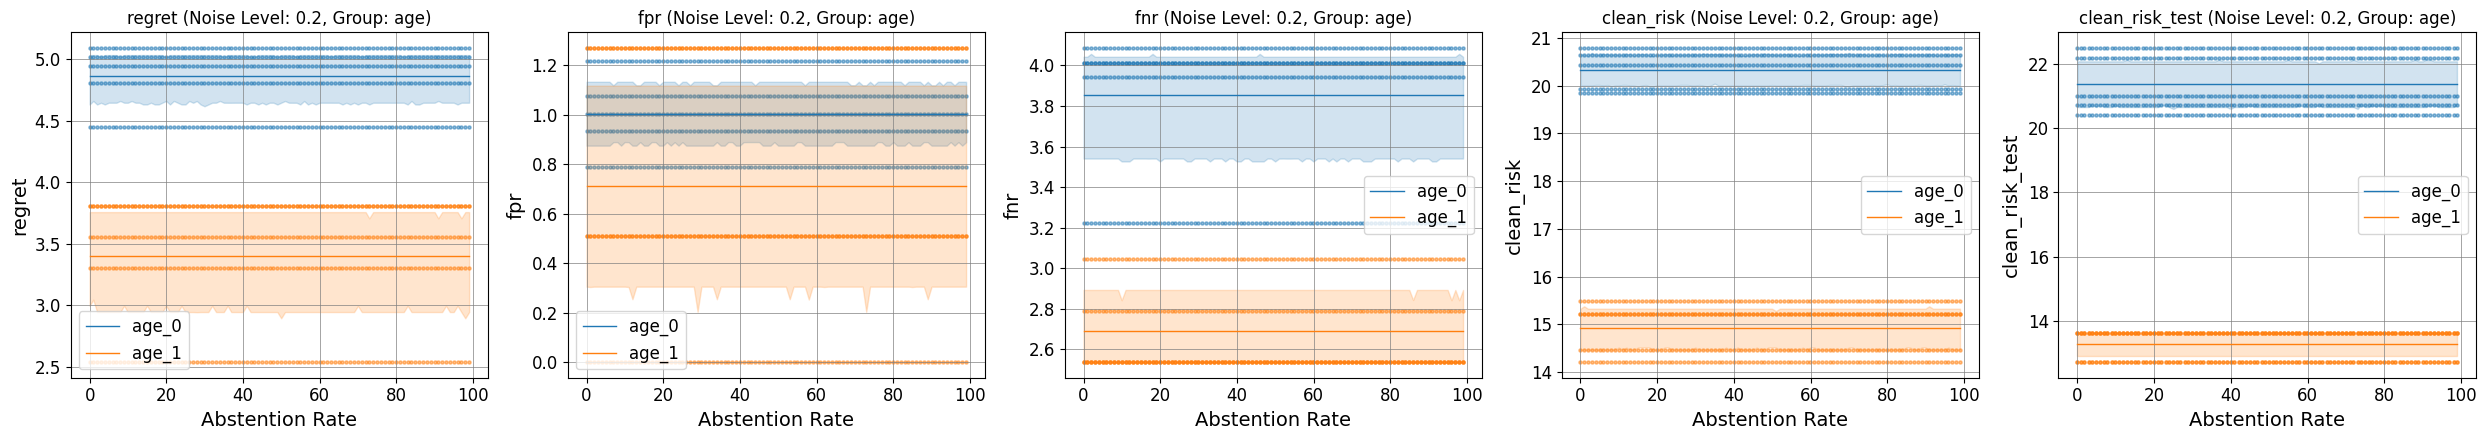

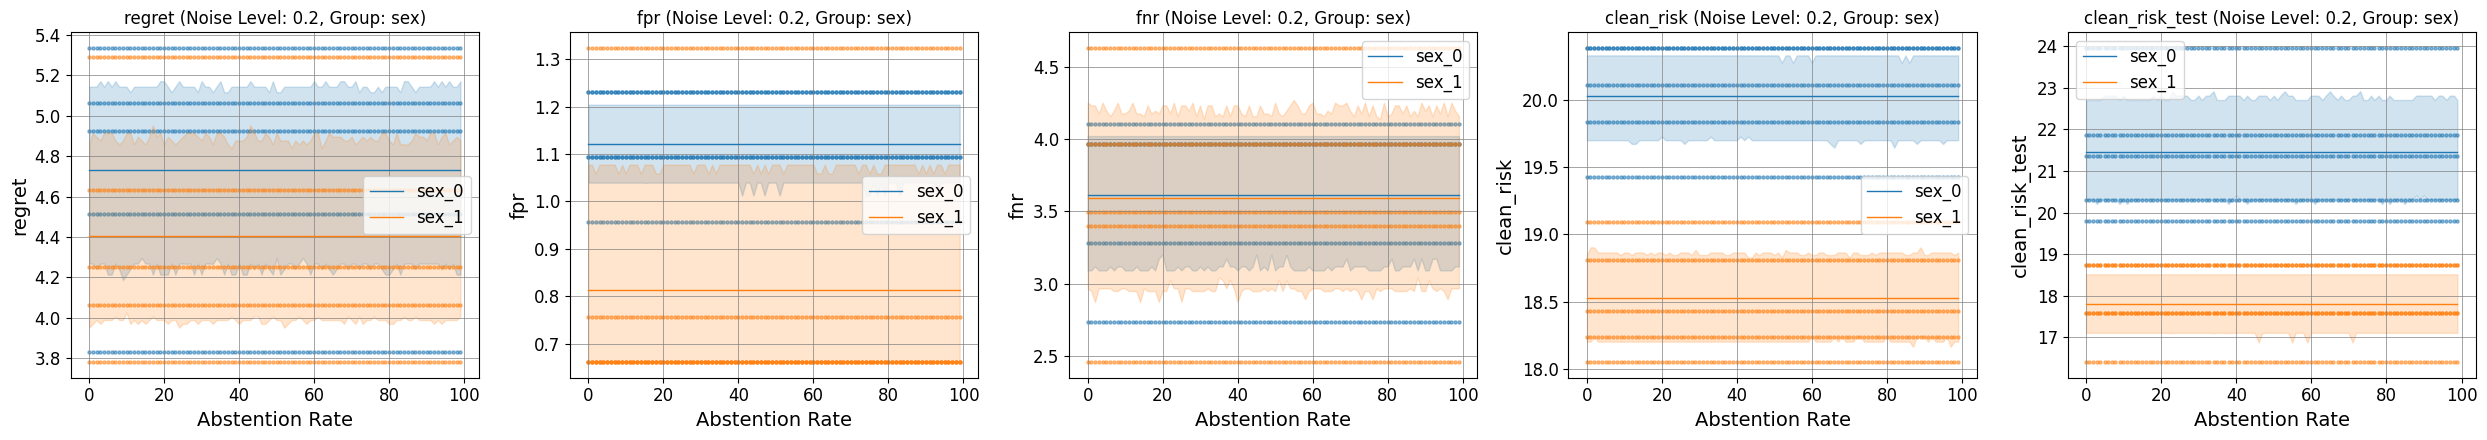

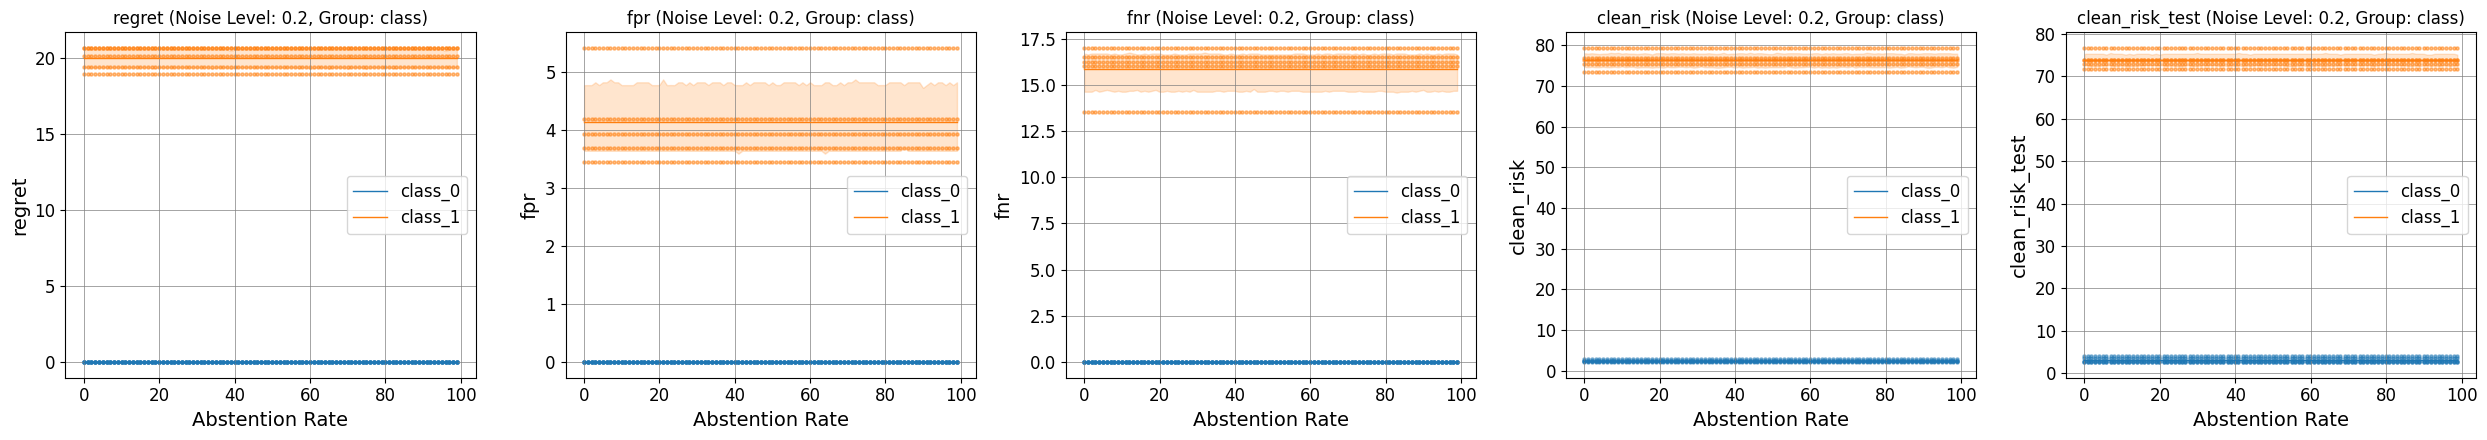

In [156]:
metrics = ["regret", "fpr", "fnr", "clean_risk", "clean_risk_test"] #data.metric.unique()

# Plot group level metrics
group_data = data[(data["loss"] == "BCE") & (data["noise"] == noise_level) &(data["method"] == "ambiguity")]

for group in group_data["group"].str.split("_").str[0].unique():

    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))  # Create a new figure with multiple columns

    sub_data = group_data[group_data["group"].str.contains(f"{group}_")]

    for metric, ax in zip(metrics, axes):
        for hue in sub_data.group.unique():

            method_data = sub_data[(sub_data['group'] == hue)& (sub_data['metric'] == metric)]
            sns.lineplot(data=method_data, x="abstention", y="value", ax=ax, linewidth=1, label=hue)
            ax.scatter(method_data["abstention"].values, method_data["value"].values, s=5, alpha=0.5)

        ax.set_xlabel("Abstention Rate", fontsize=14)
        ax.set_ylabel(metric, fontsize=14)
        ax.set_title(f"{metric} (Noise Level: {noise_level}, Group: {group})")

        ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        ax.legend(fontsize=12, title_fontsize=14)  # Add legend here

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

In [157]:
method_data

metric      value    coverage  threshold  noise loss  \
94805   clean_risk_test  73.786408  100.000000       0.00    0.2  BCE   
94811   clean_risk_test  73.786408   99.107143       0.01    0.2  BCE   
94817   clean_risk_test  73.786408   98.214286       0.02    0.2  BCE   
94823   clean_risk_test  73.786408   97.098214       0.03    0.2  BCE   
94829   clean_risk_test  73.786408   96.205357       0.04    0.2  BCE   
...                 ...        ...         ...        ...    ...  ...   
119375  clean_risk_test  71.844660    5.133929       0.95    0.2  BCE   
119381  clean_risk_test  71.844660    4.017857       0.96    0.2  BCE   
119387  clean_risk_test  71.844660    3.125000       0.97    0.2  BCE   
119393  clean_risk_test  71.844660    2.008929       0.98    0.2  BCE   
119399  clean_risk_test  71.844660    1.116071       0.99    0.2  BCE   

          group  draw_id     method  abstention  
94805   class_1        0  ambiguity    0.000000  
94811   class_1        0  ambiguity    0.892857  
94817   class_1        0  ambiguity    1.785714  
94823   class_1        0  ambiguity    2.901786  
94829   class_1        0  ambiguity    3.794643  
...         ...      ...        ...         ...  
119375  class_1        4  ambiguity   94.866071  
119381  class_1        4  ambiguity   95.982143  
119387  class_1        4  ambiguity   96.875000  
119393  class_1        4  ambiguity   97.991071  
119399  class_1        4  ambiguity   98.883929  

[500 rows x 10 columns]

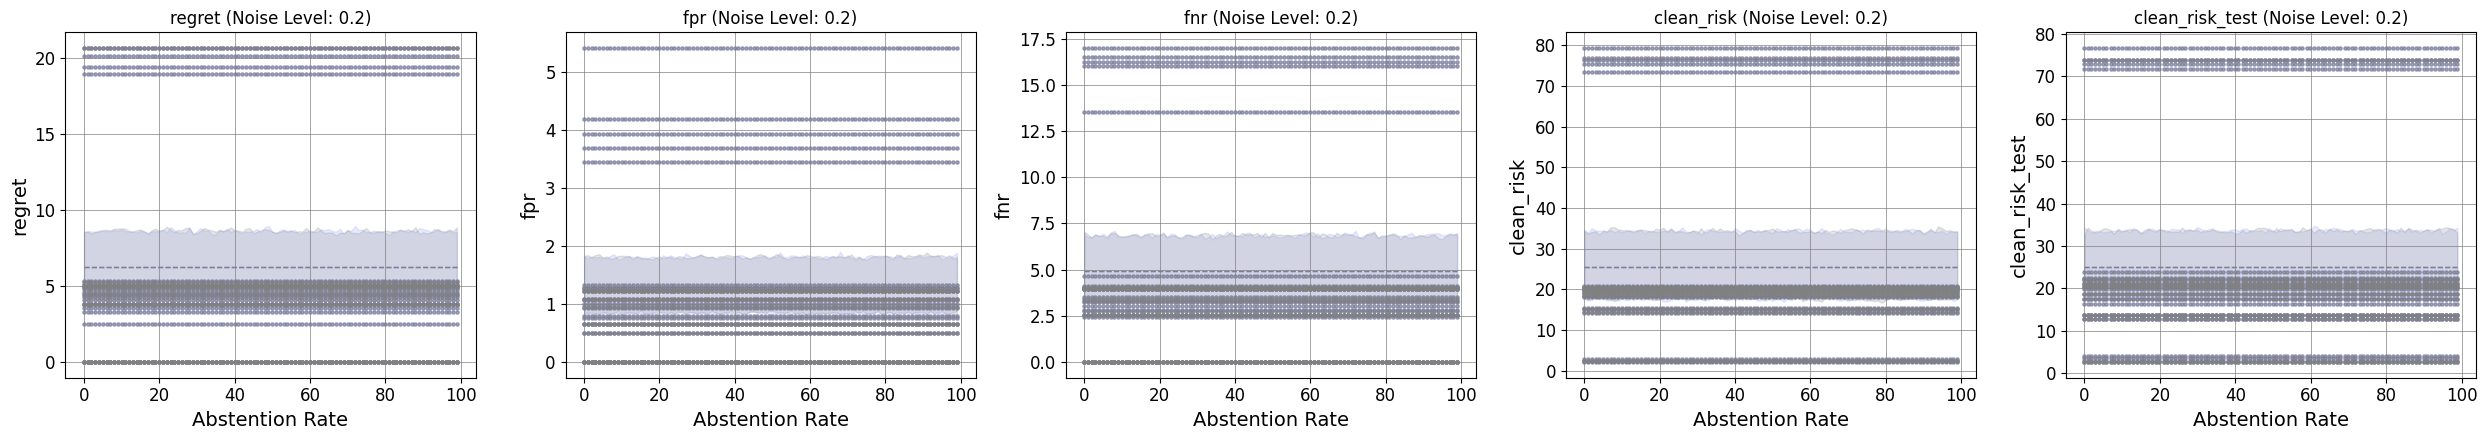

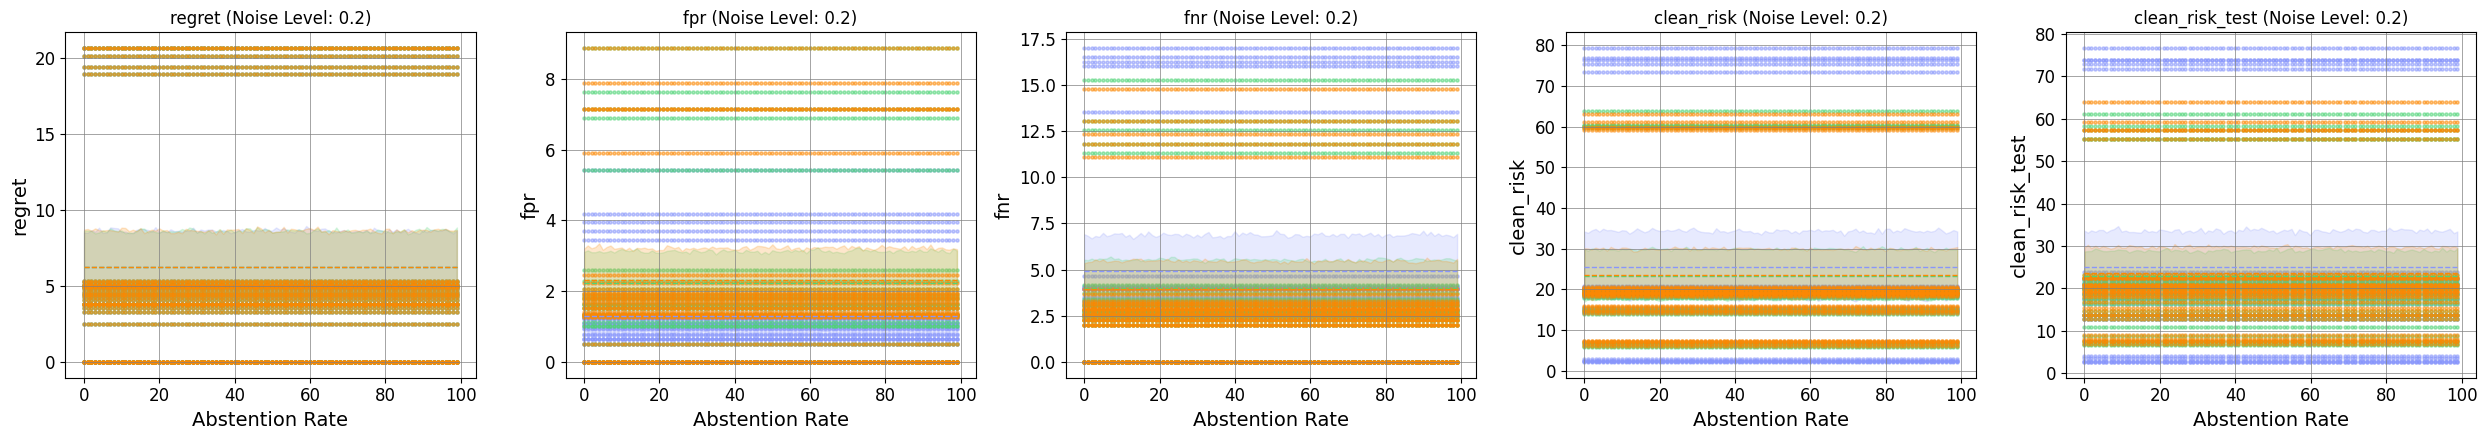

KeyboardInterrupt: 

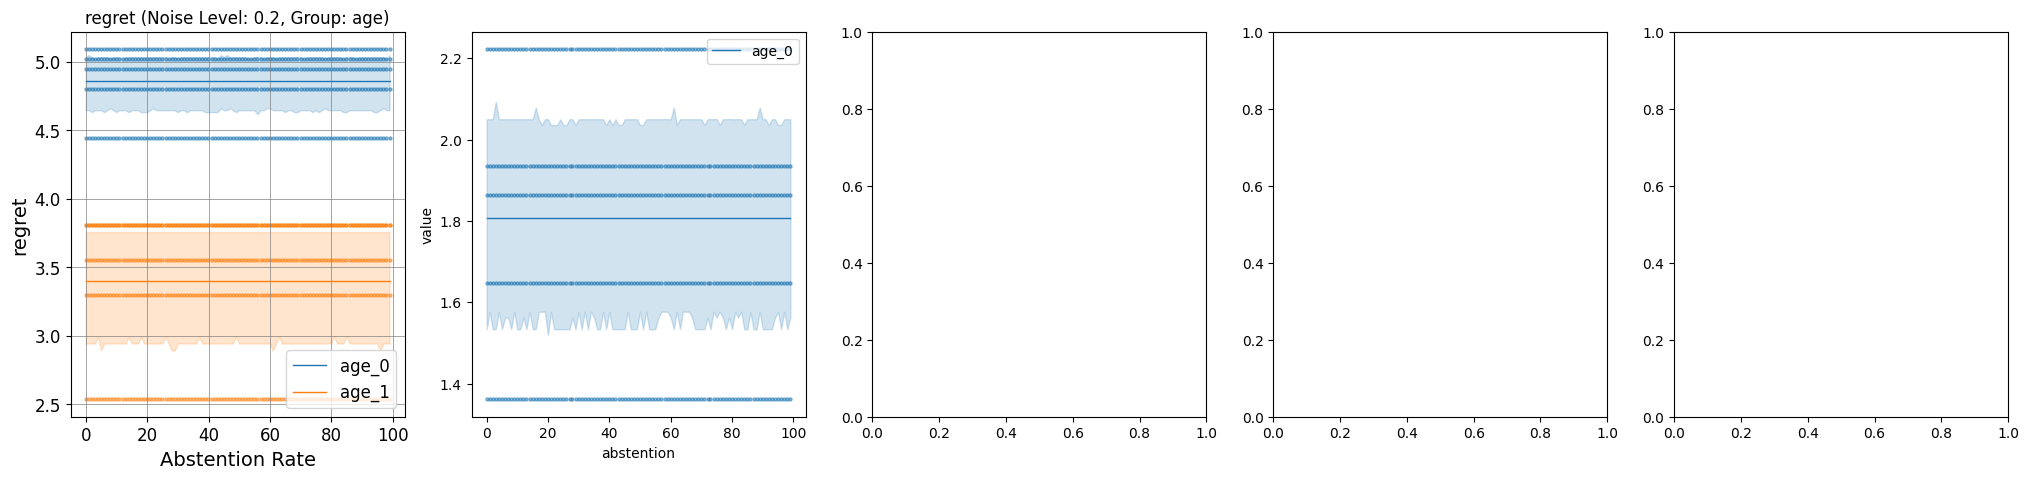

In [152]:
for noise_level in [0.2]:
    plot_metrics(data, noise_level = noise_level, group = True)

In [147]:
noise_type = "class_independent"
fixed_class = 0
fixed_noise = 0.0
misspecify = "correct"
model_type = "NN"
dataset = "cshock_eicu"



# for dataset in tqdm(["cshock_eicu_imbalanced", "cshock_mimic_imbalanced", "cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer", "saps_imbalanced", "support_imbalanced", "lungcancer_imbalanced"]):
#     for model_type in ["LR", "NN"]:
#         for noise_type in ["class_independent", "class_conditional"]:

#             try:
#                 data = calculate_metrics_abstain(dataset, noise_type = noise_type, fixed_class=fixed_class, fixed_noise = fixed_noise, misspecify = misspecify)
#                 data.to_csv(f"/h/snagaraj/noise_multiplicity/results/abstain_metrics_{dataset}_{noise_type}_{model_type}_{fixed_class}_{fixed_noise}_{misspecify}.csv")
#                 print(dataset)
#                 #plot_metrics(data)
#             except:
#                 continue

  0%|          | 0/10 [00:00<?, ?it/s]

cshock_eicu_imbalanced
cshock_eicu_imbalanced
cshock_eicu_imbalanced
cshock_eicu_imbalanced
cshock_mimic_imbalanced
cshock_mimic_imbalanced
cshock_mimic_imbalanced
cshock_mimic_imbalanced
cshock_eicu
cshock_eicu
cshock_eicu
cshock_eicu
cshock_mimic
cshock_mimic
cshock_mimic
cshock_mimic
saps
saps
support
support
support
support
lungcancer
lungcancer
lungcancer
lungcancer
support_imbalanced
support_imbalanced
support_imbalanced
support_imbalanced
lungcancer_imbalanced
lungcancer_imbalanced
lungcancer_imbalanced
lungcancer_imbalanced


In [31]:
data

Unnamed: 0     Regret  Risk_Train  Risk_Test  Coverage_Train  \
0                0   2.643115   33.496648  34.793814        0.000000   
1                1   2.263297   33.609959  35.410334        0.000000   
2                2   3.567274   36.603335  34.638554        0.000000   
3                3   2.098179   30.205859  34.304207        0.000000   
4                4   2.865497   33.157895  35.705669        0.000000   
...            ...        ...         ...        ...             ...   
107995      107995  11.538462    3.846154  37.500000        0.989943   
107996      107996  20.000000   22.857143  37.500000        0.989943   
107997      107997  13.953488    4.651163  16.666667        0.989943   
107998      107998   0.000000   20.930233  16.666667        0.989943   
107999      107999  37.142857    2.857143  28.571429        0.989943   

        Coverage_Test        FPR       FNR  Threshold  Noise Level     Loss  \
0            0.000000   1.431150  1.211965       0.00         0.05      BCE   
1            0.000000   1.395700  0.867597       0.00         0.05      BCE   
2            0.000000   1.667313  1.899961       0.00         0.05      BCE   
3            0.000000   1.227237  0.870942       0.00         0.05      BCE   
4            0.000000   1.666667  1.198830       0.00         0.05      BCE   
...               ...        ...       ...        ...          ...      ...   
107995       0.989691  11.538462  0.000000       0.99         0.40  forward   
107996       0.989691  20.000000  0.000000       0.99         0.40  forward   
107997       0.989691  13.953488  0.000000       0.99         0.40  forward   
107998       0.989691   0.000000  0.000000       0.99         0.40  forward   
107999       0.989691  37.142857  0.000000       0.99         0.40  forward   

                Dataset  Draw_id        Method  
0               support        0     ambiguity  
1         support_age_0        0     ambiguity  
2         support_age_1        0     ambiguity  
3         support_age_2        0     ambiguity  
4         support_sex_0        0     ambiguity  
...                 ...      ...           ...  
107995    support_age_2        4  disagreement  
107996    support_sex_0        4  disagreement  
107997    support_sex_1        4  disagreement  
107998  support_class_0        4  disagreement  
107999  support_class_1        4  disagreement  

[108000 rows x 14 columns]

  0%|          | 0/9 [00:00<?, ?it/s]

cshock_eicu_imbalanced class_conditional


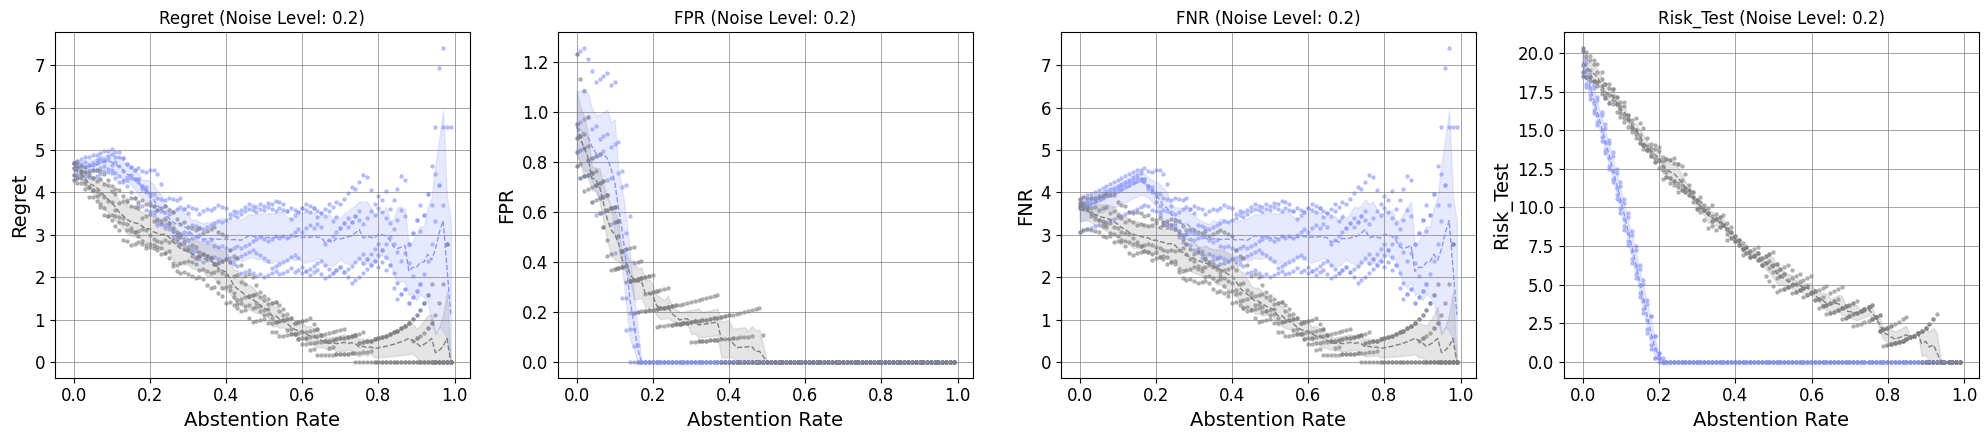

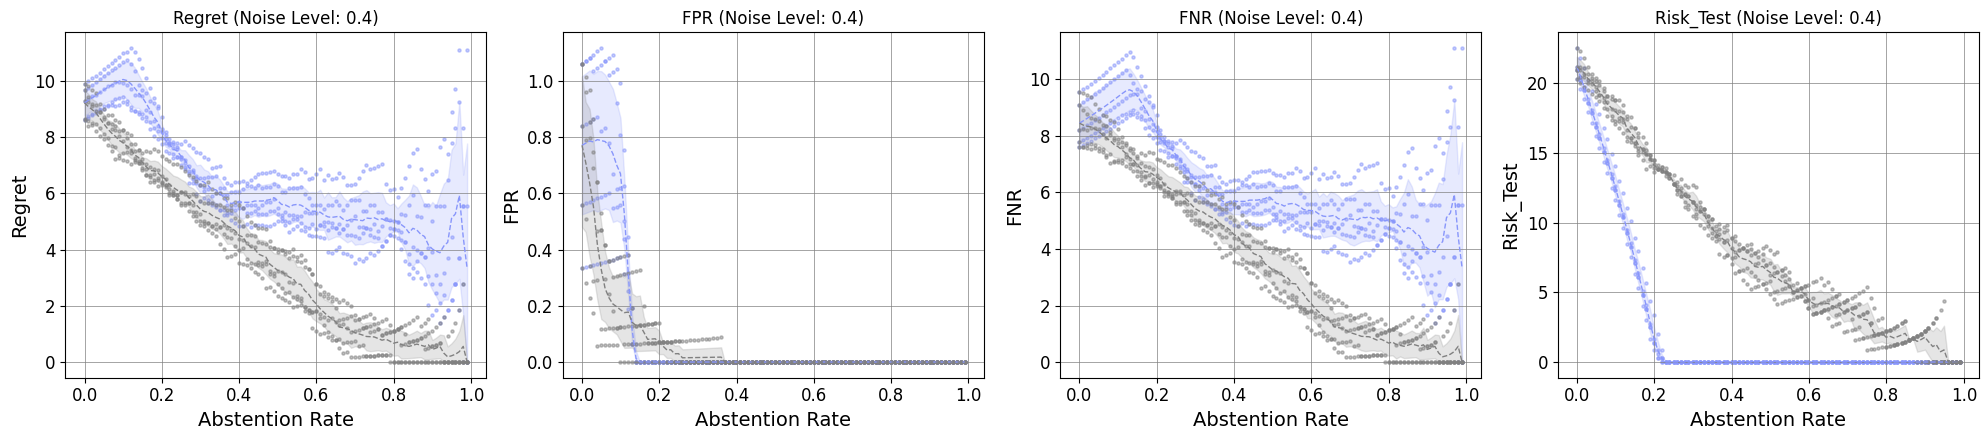

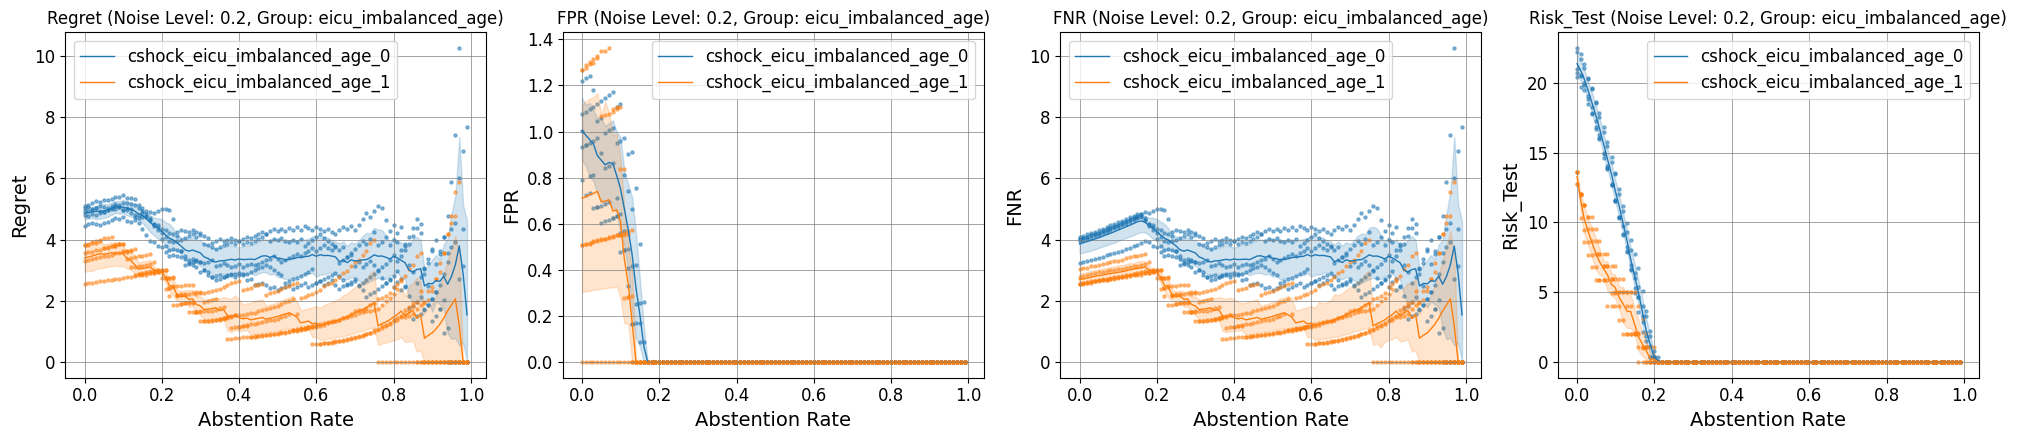

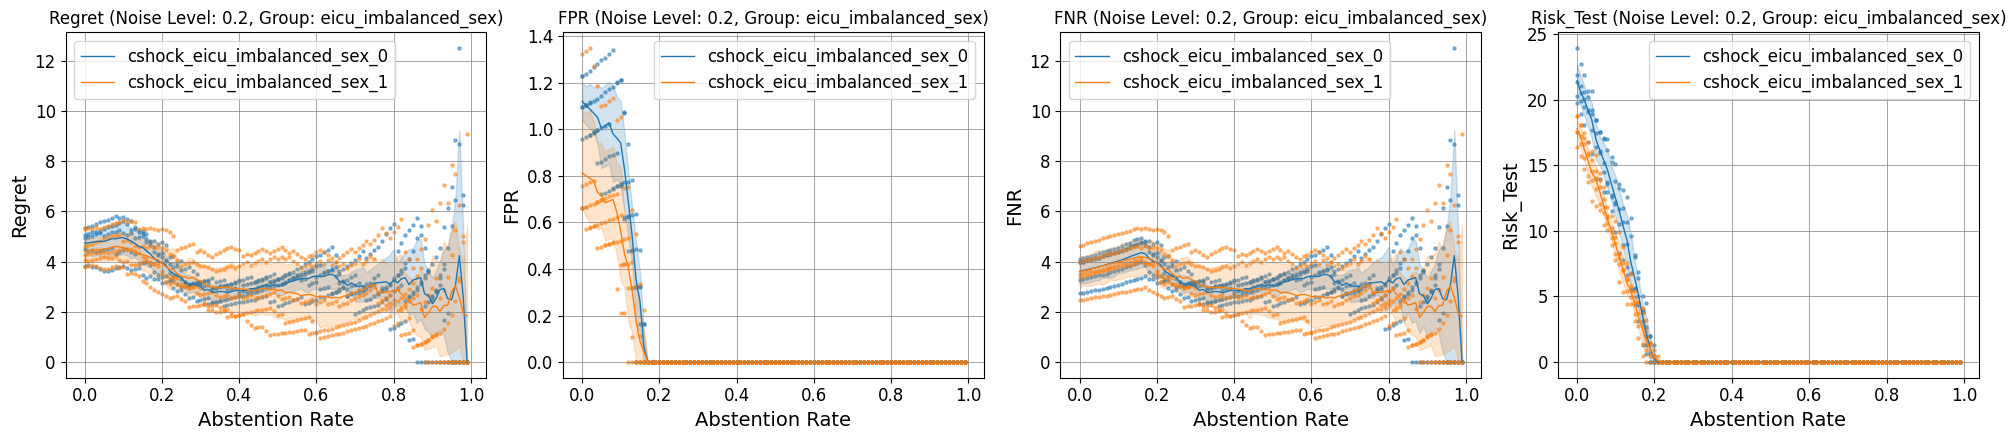

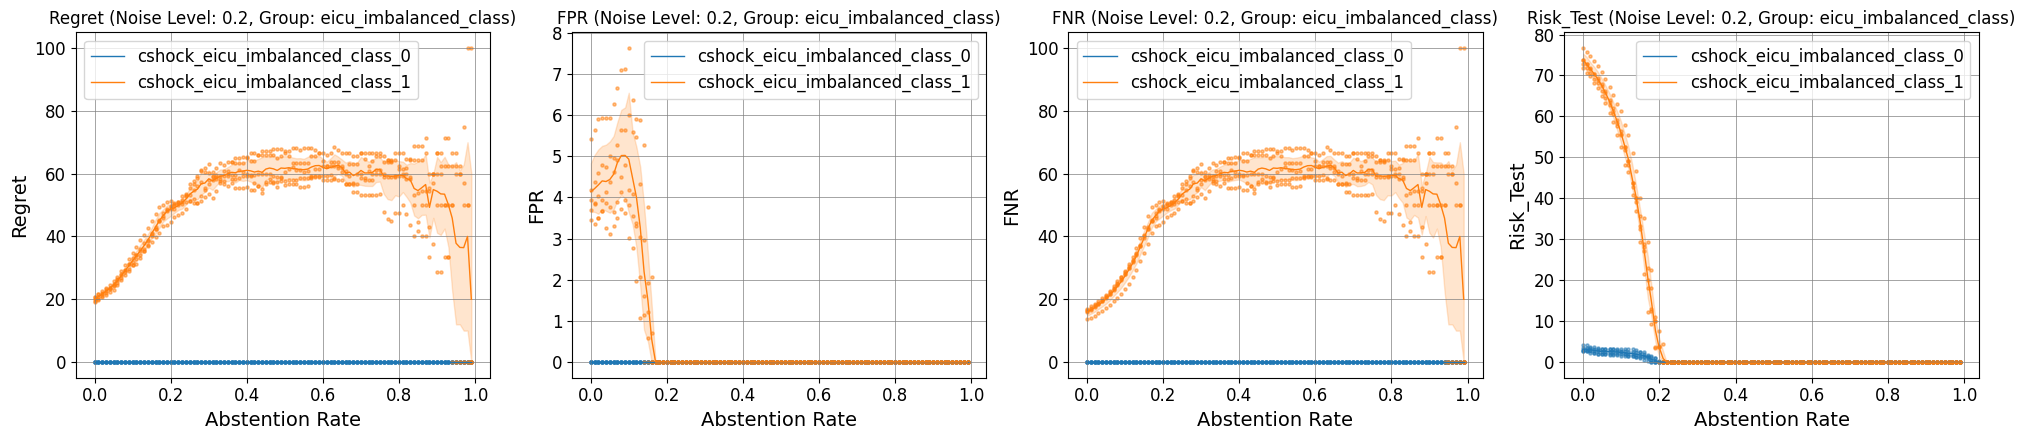

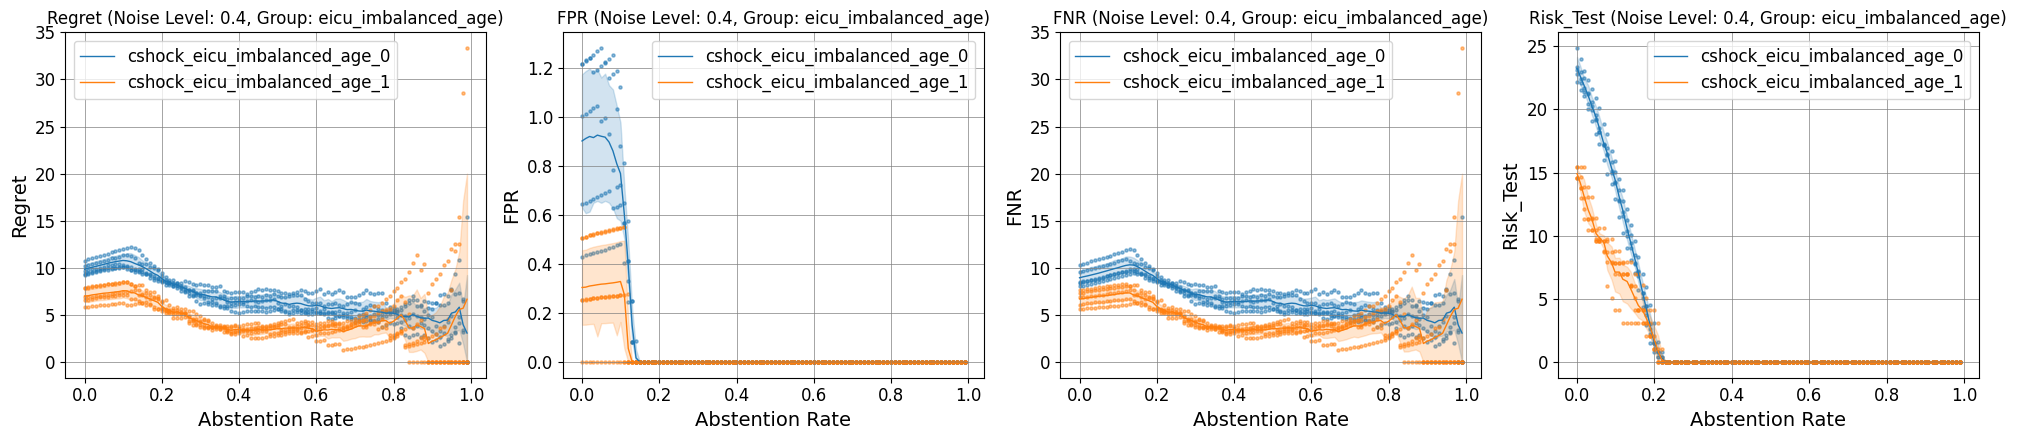

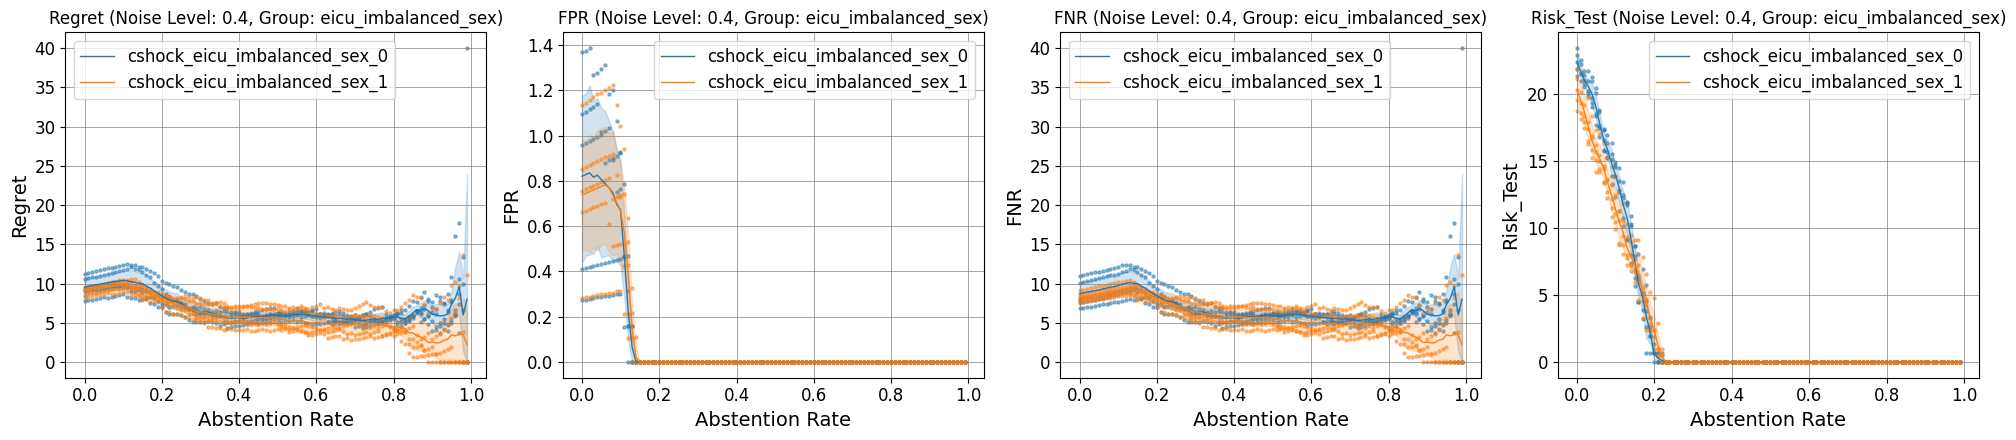

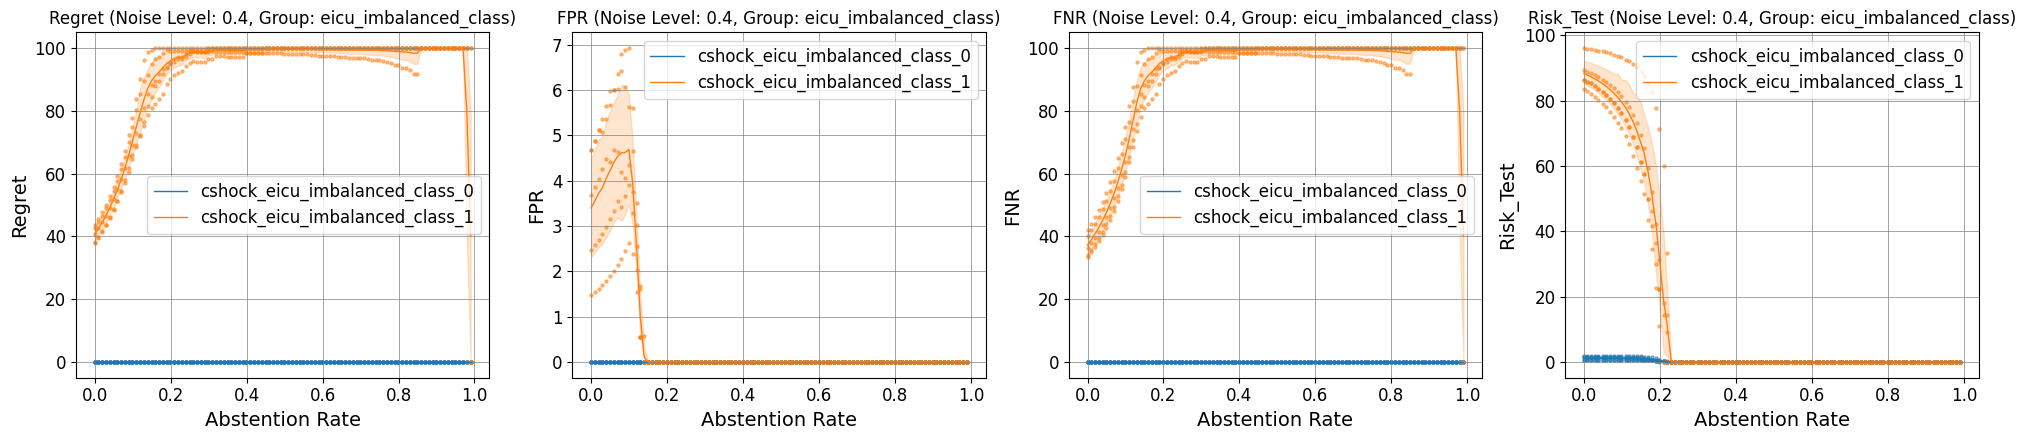

cshock_eicu class_conditional


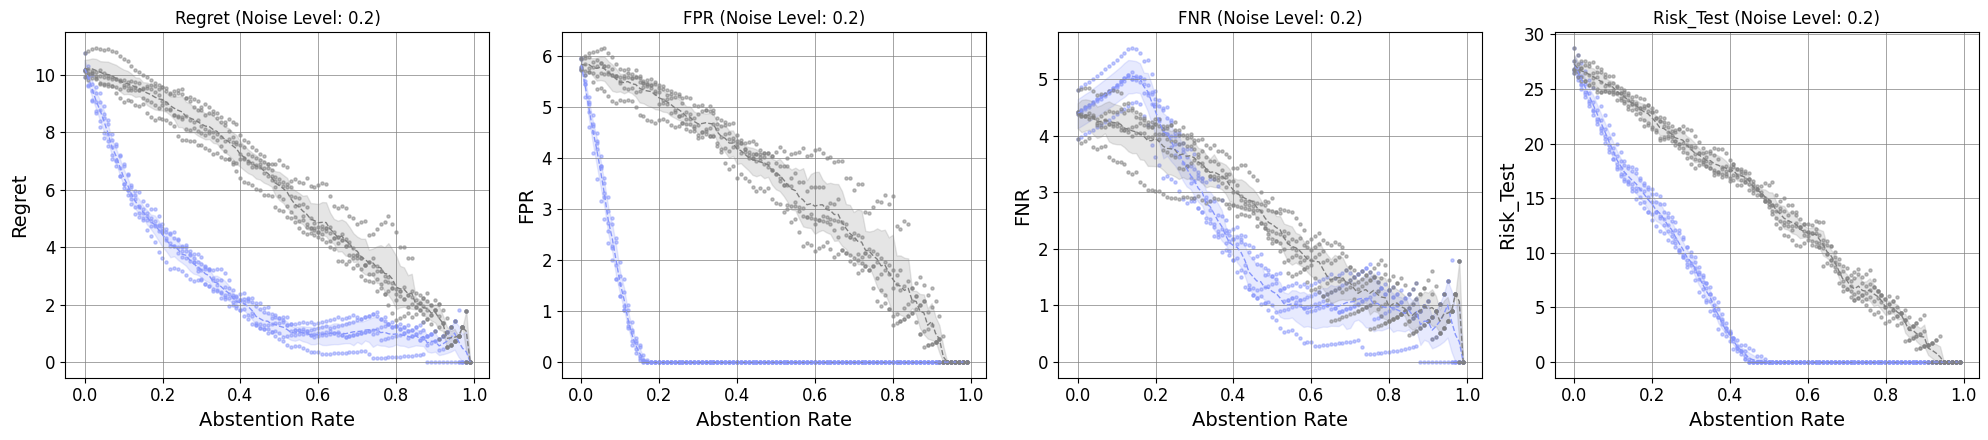

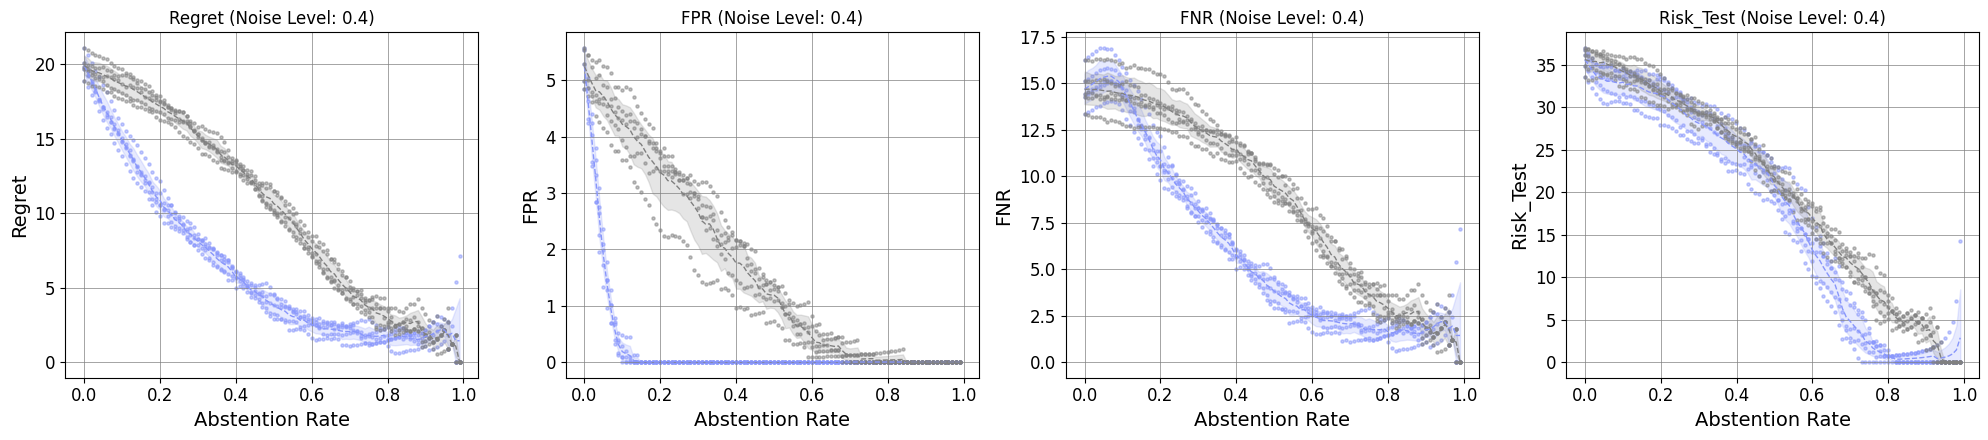

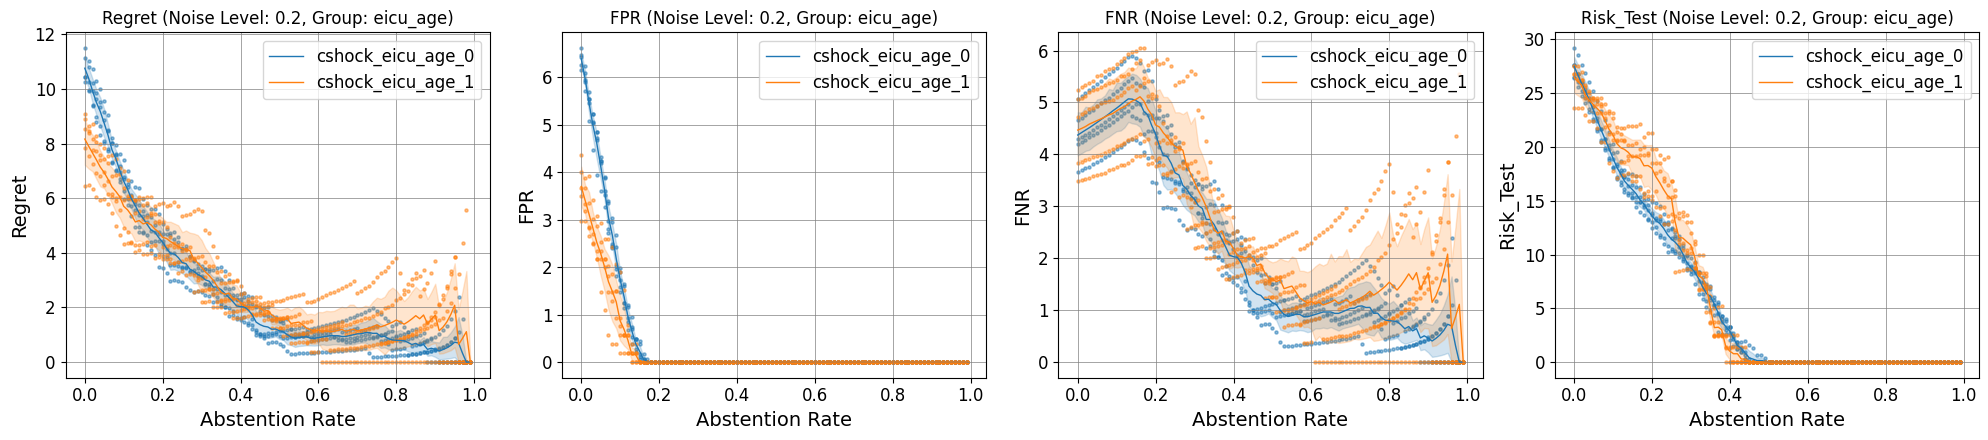

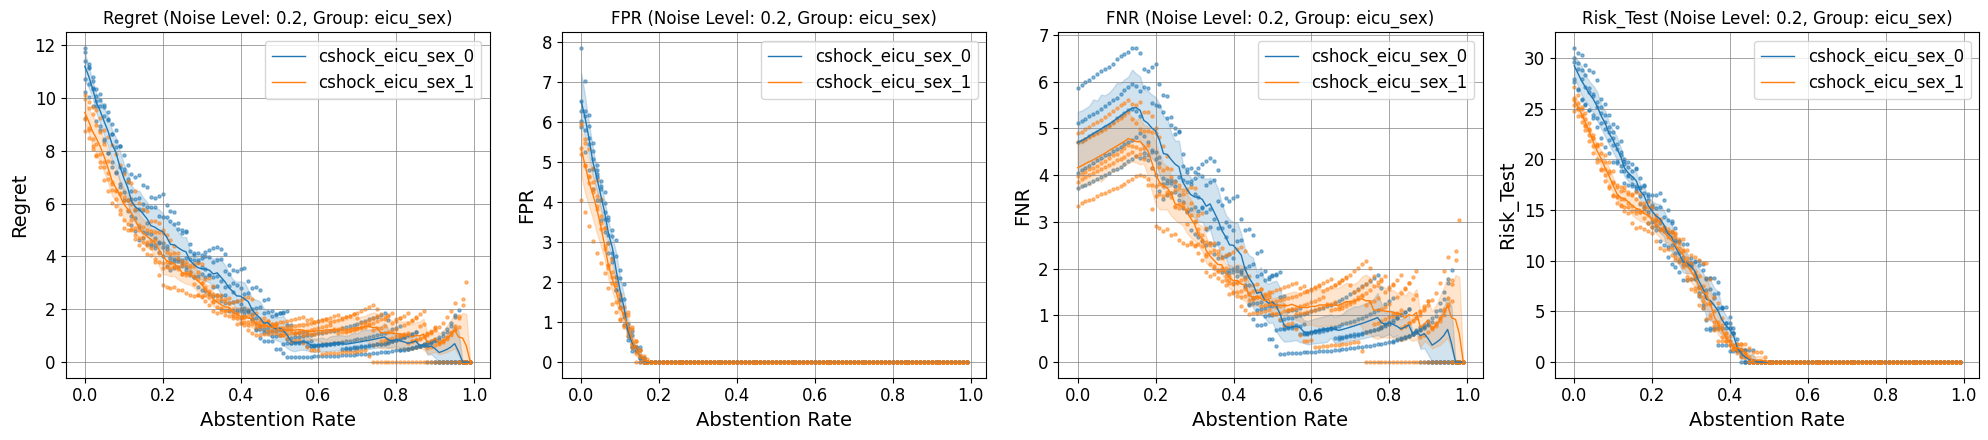

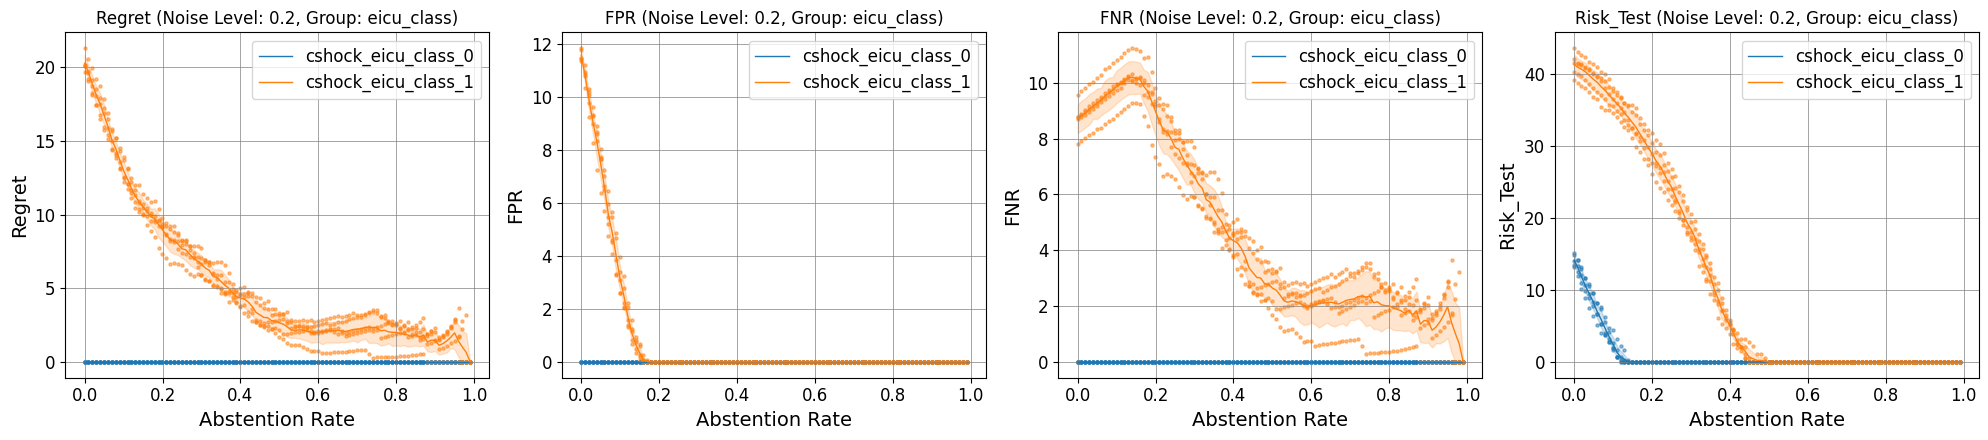

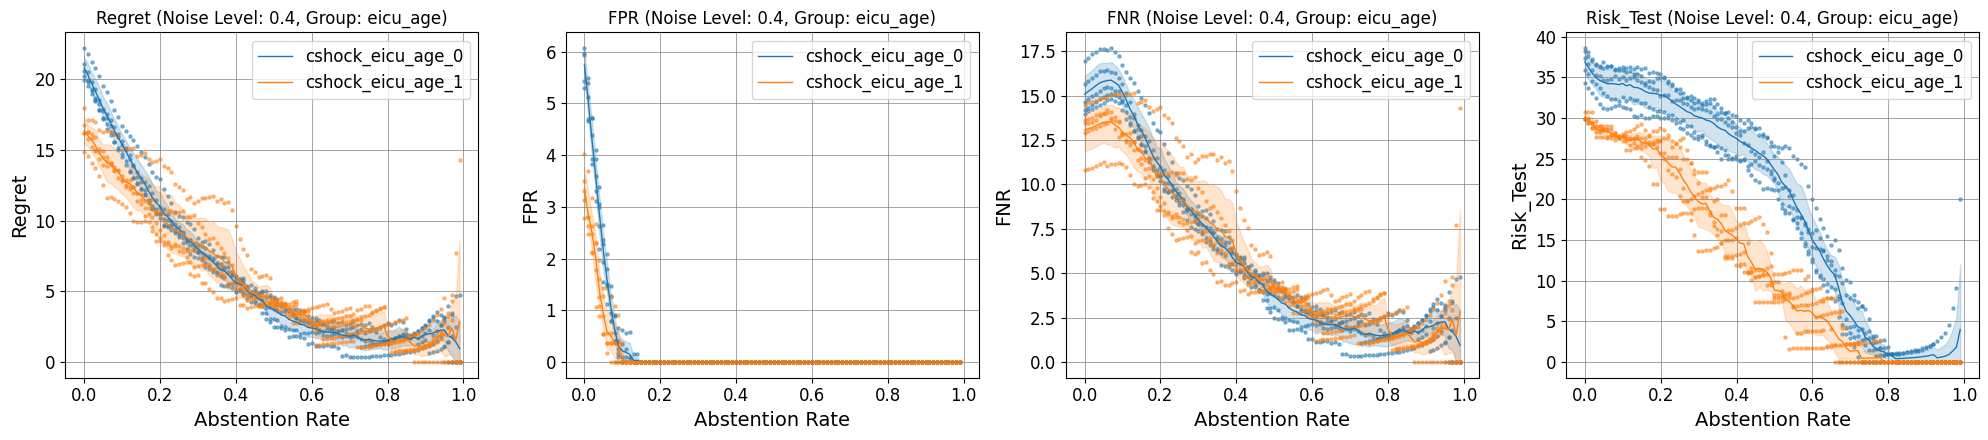

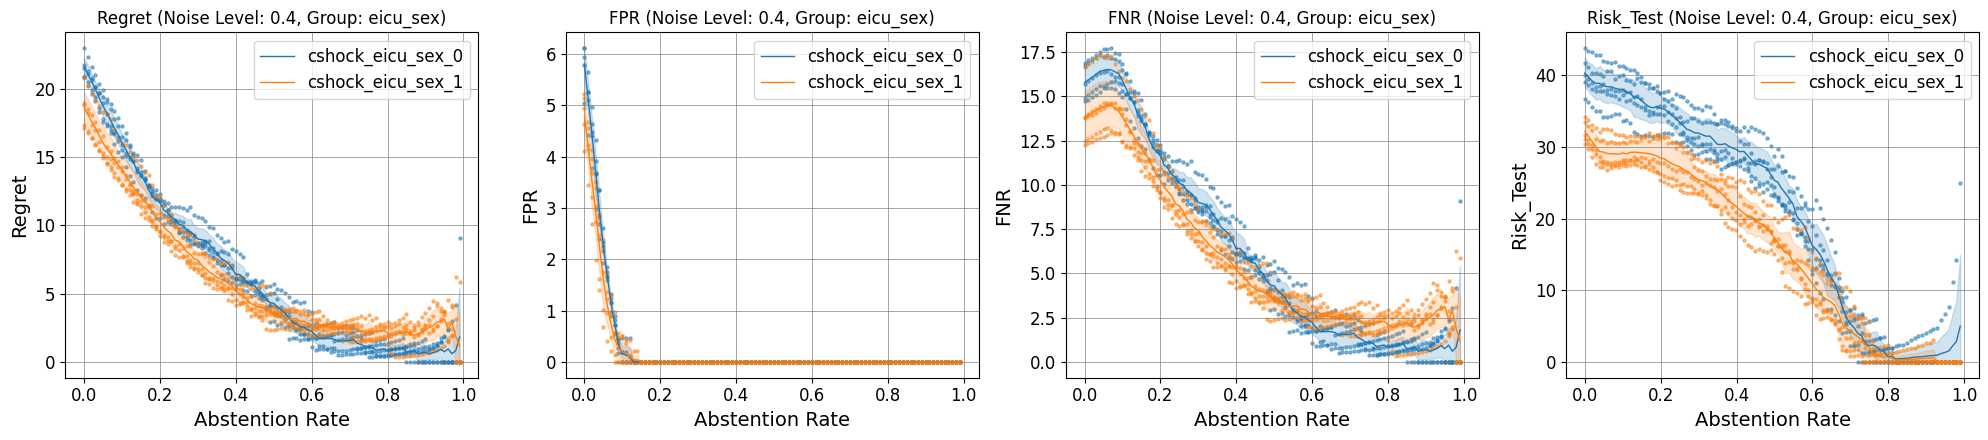

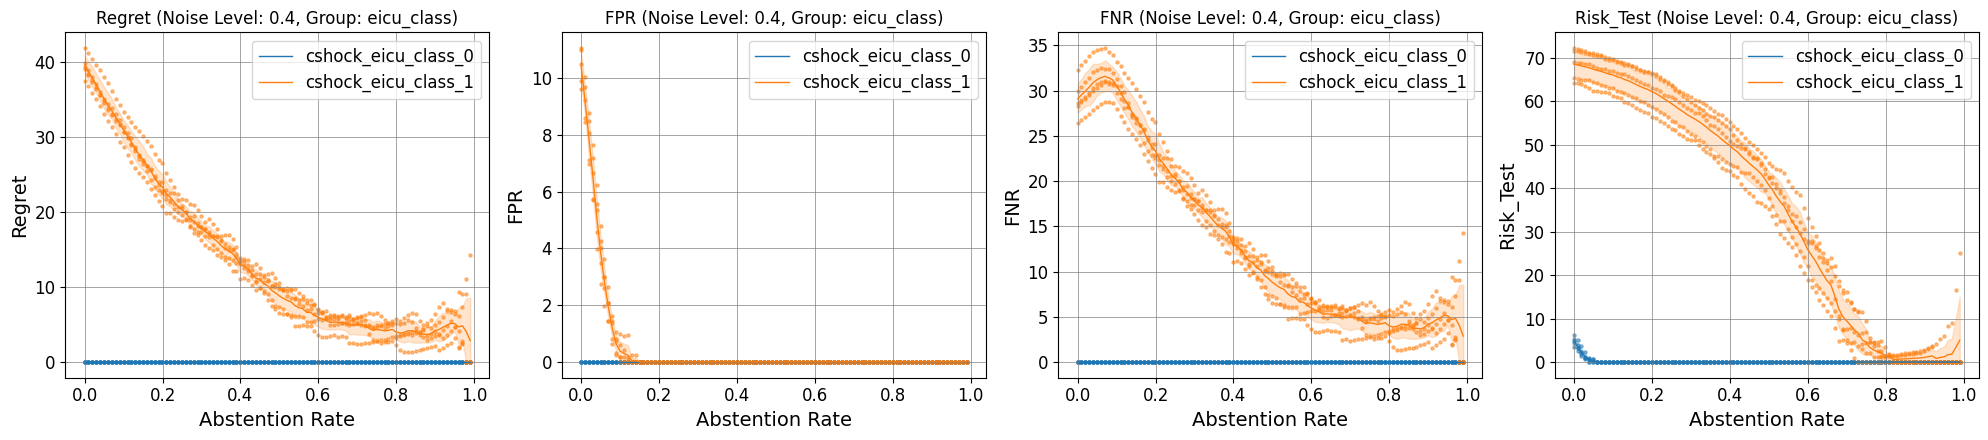

cshock_mimic class_conditional


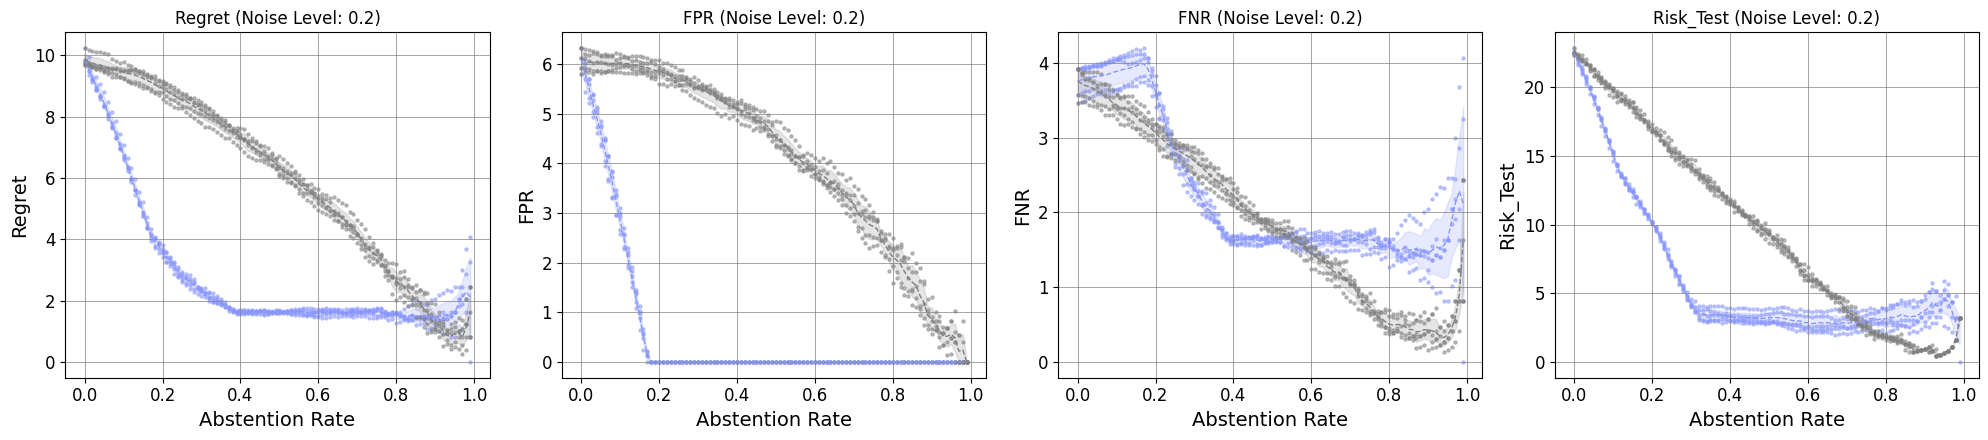

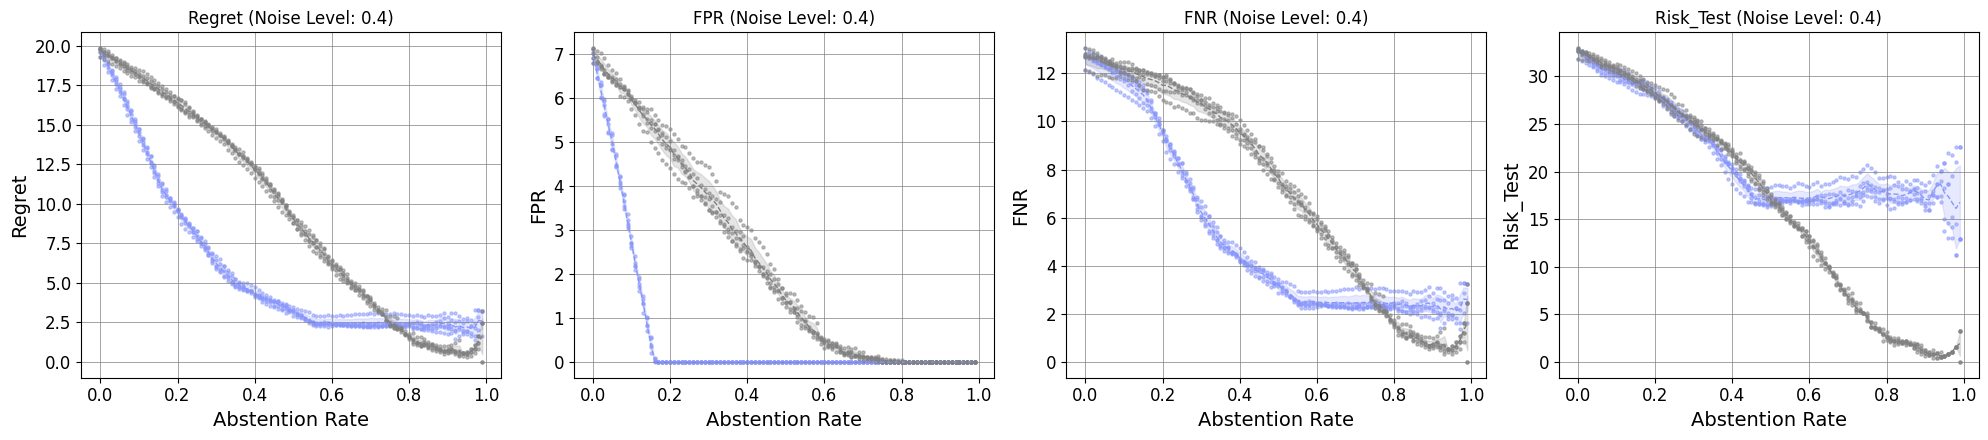

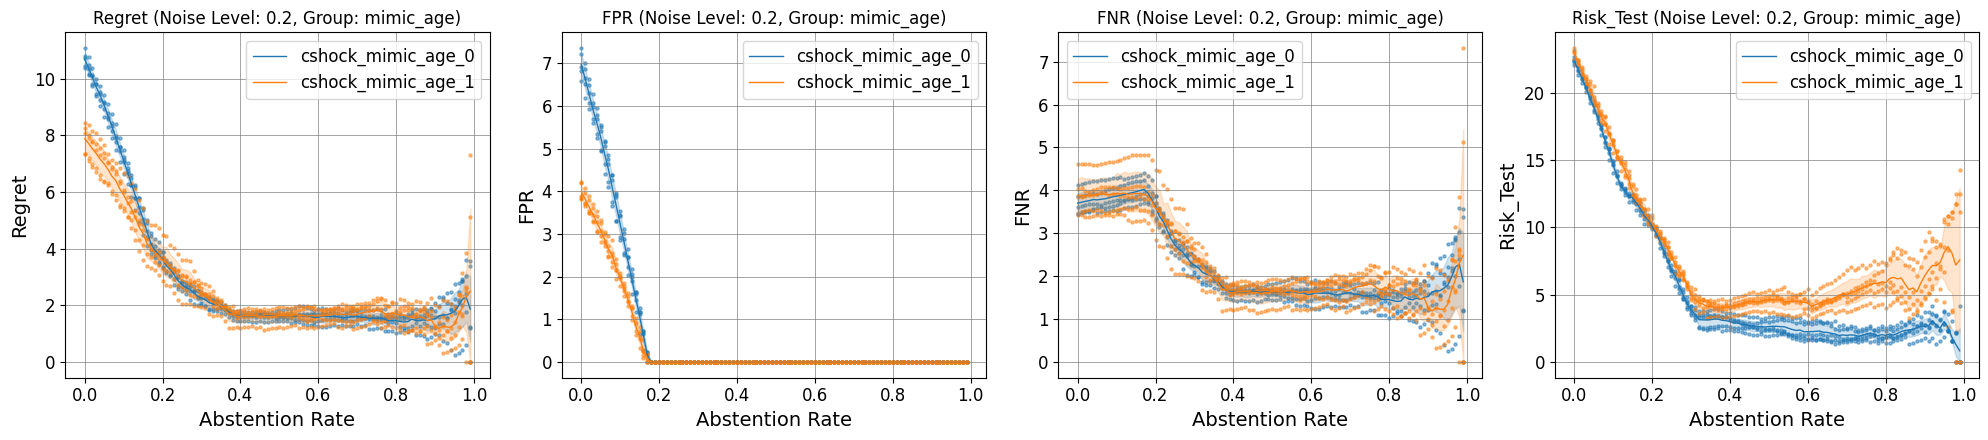

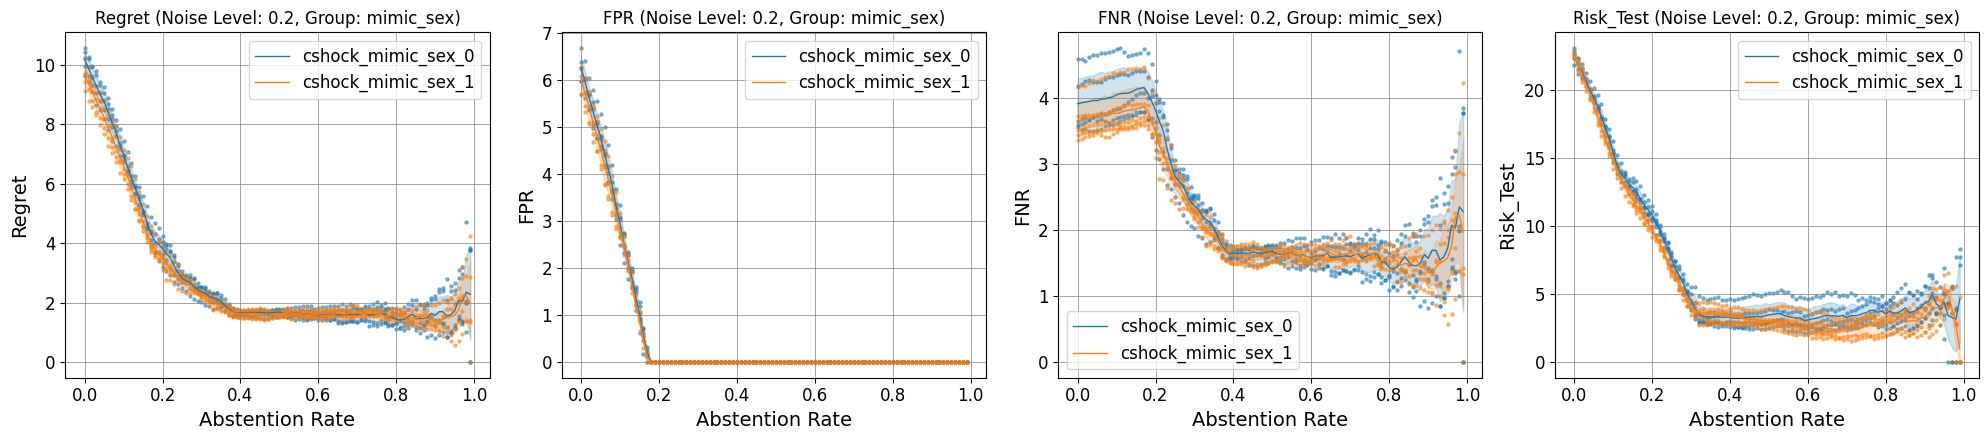

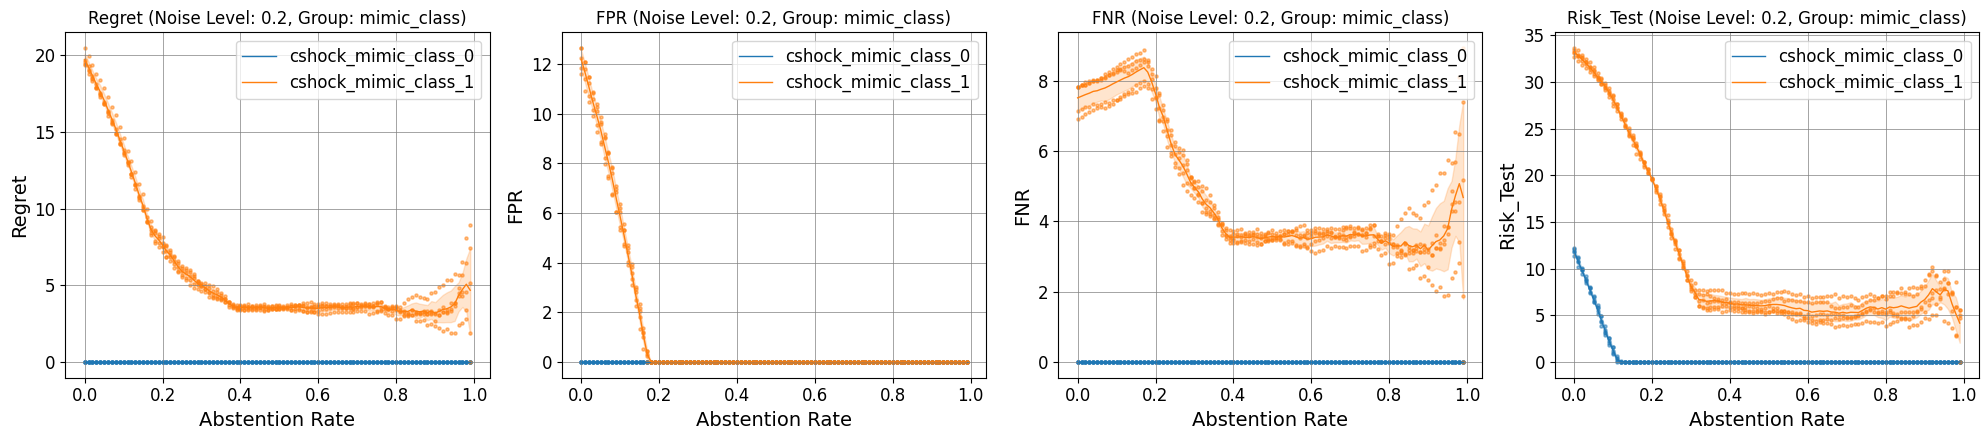

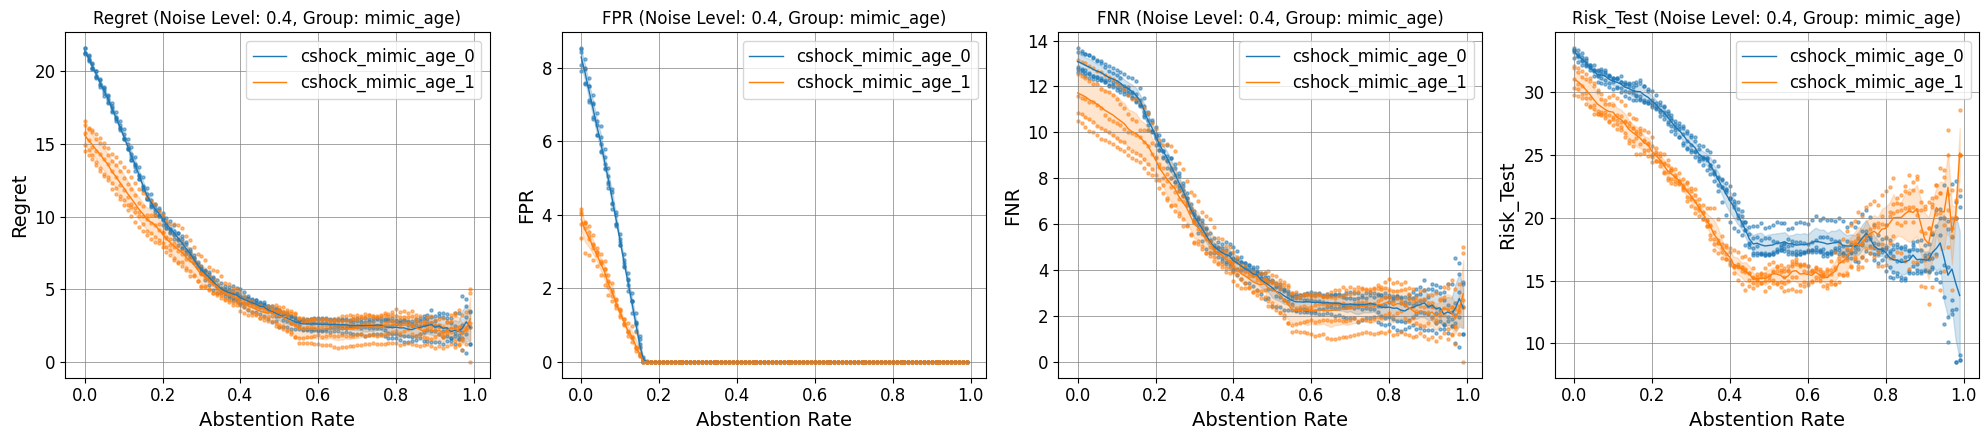

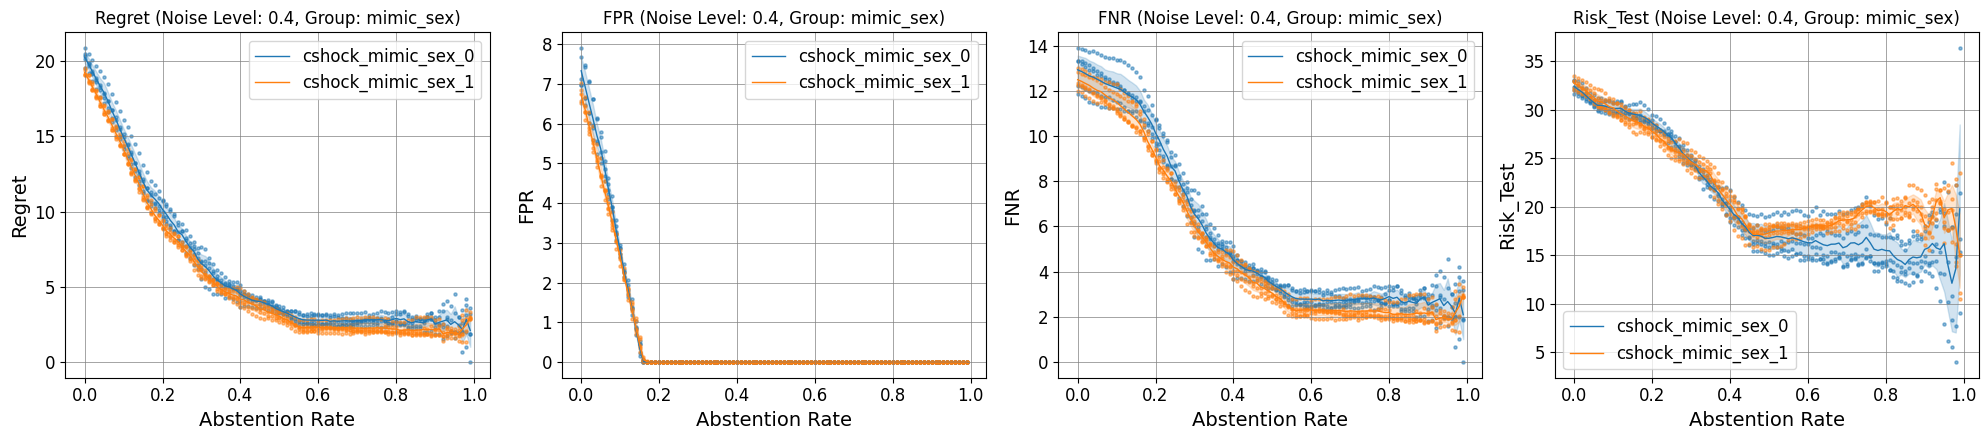

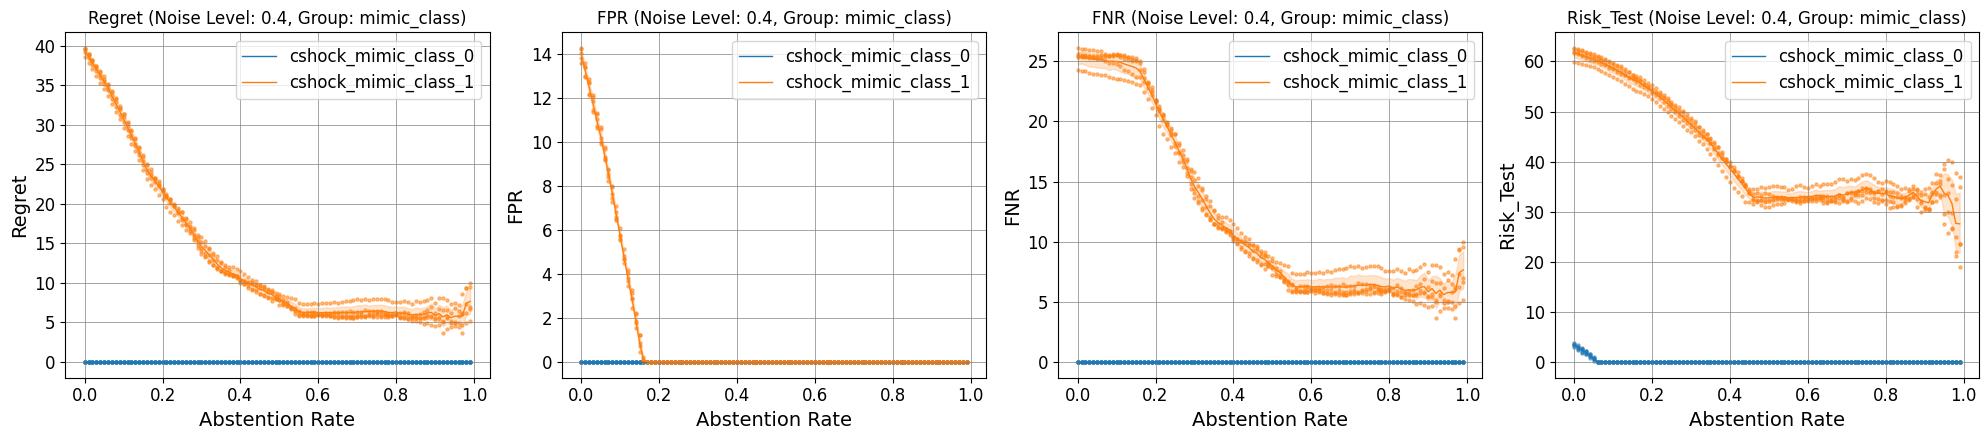

support class_conditional


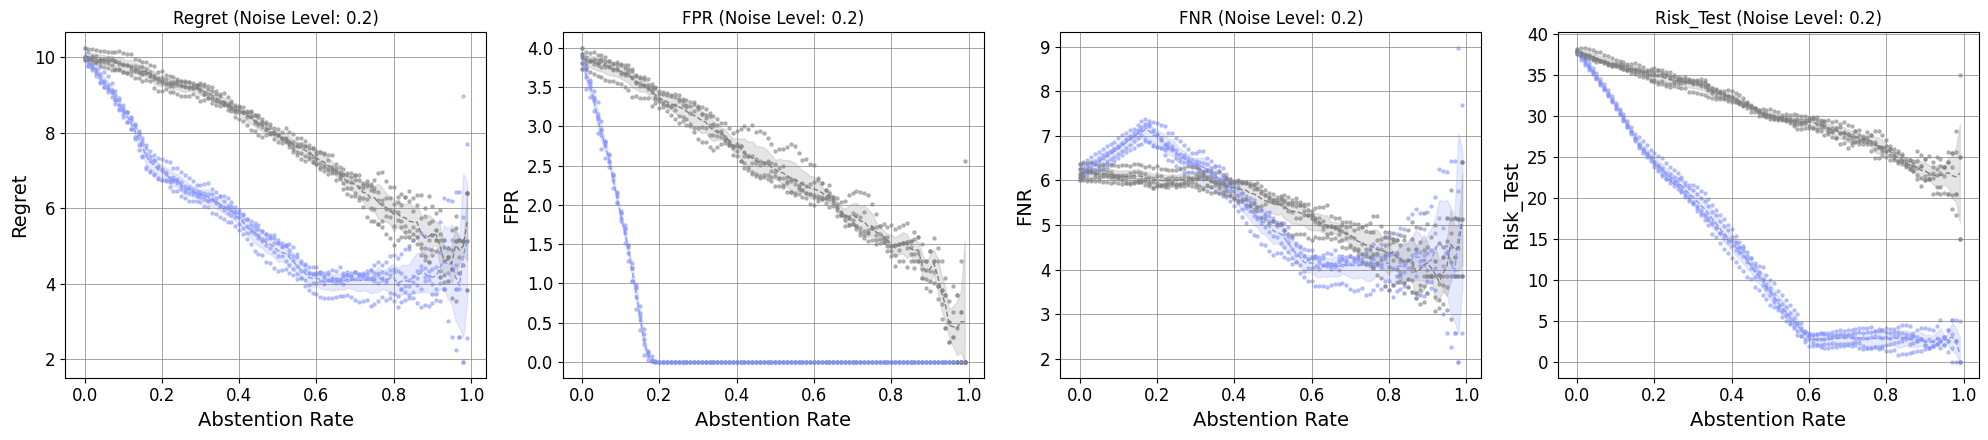

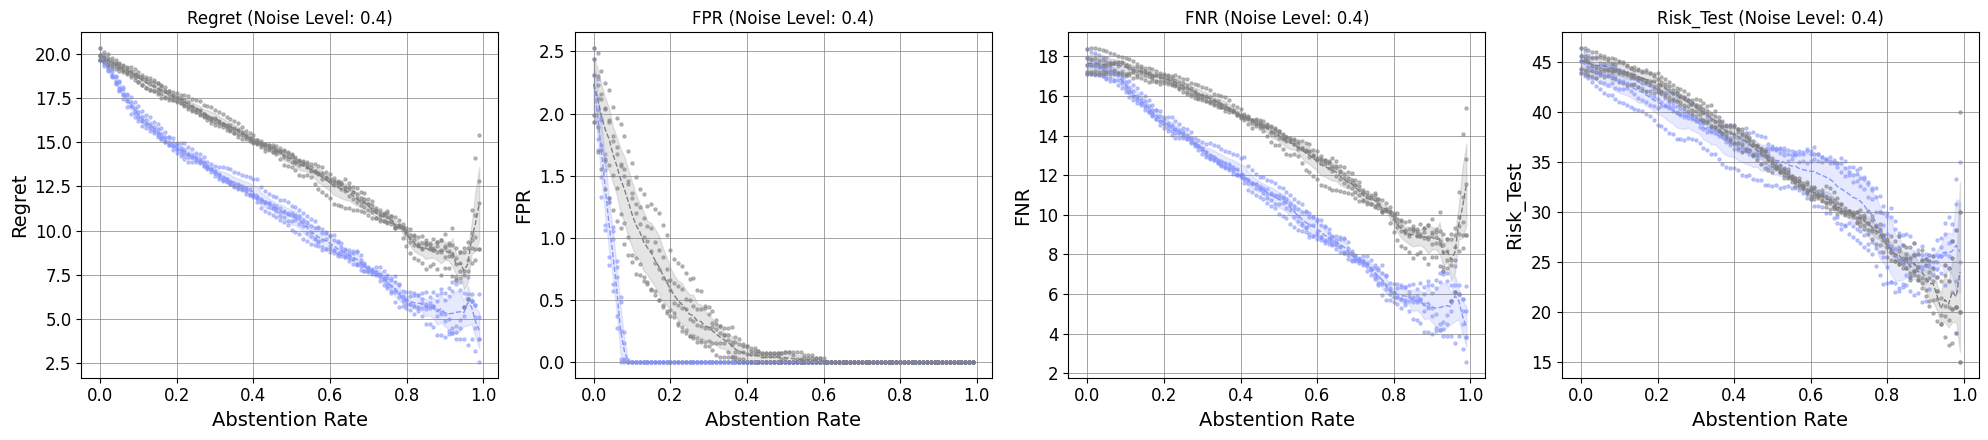

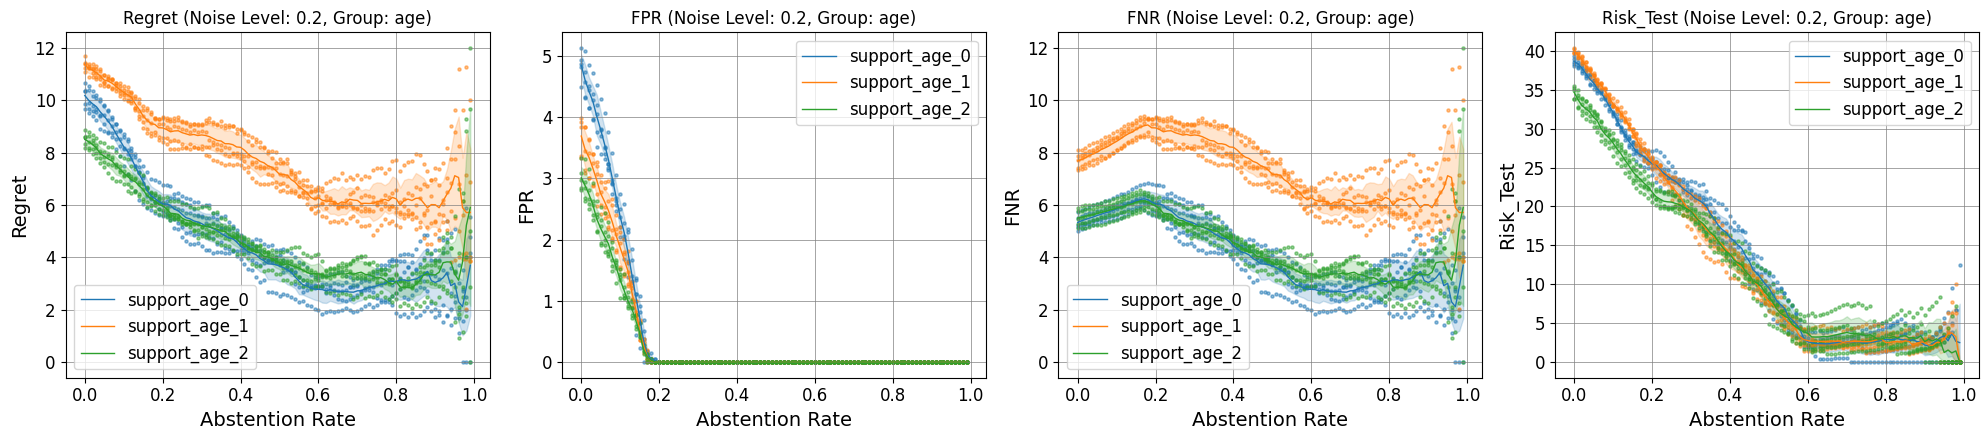

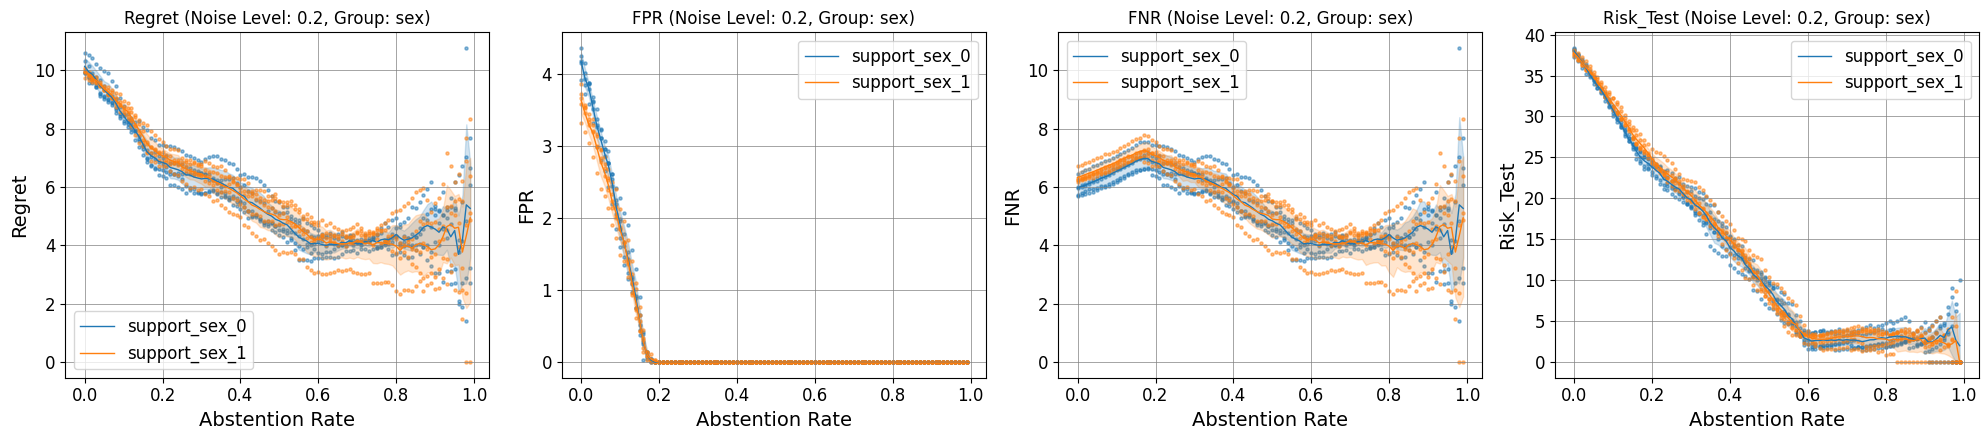

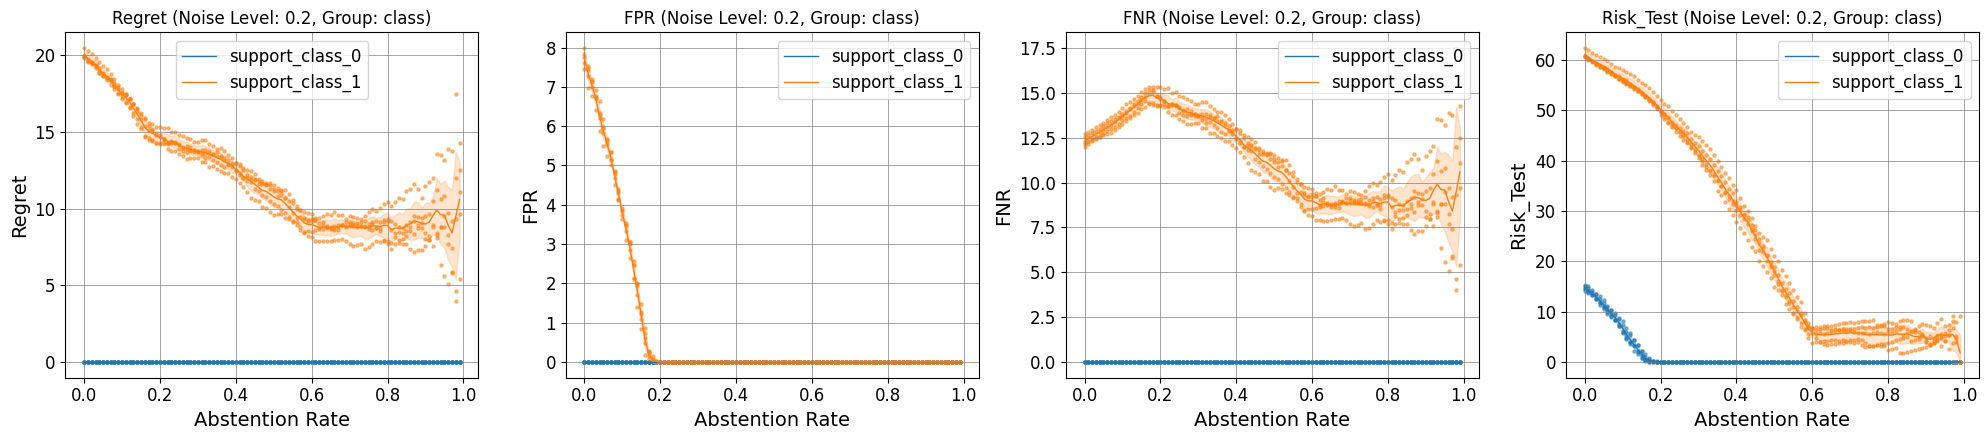

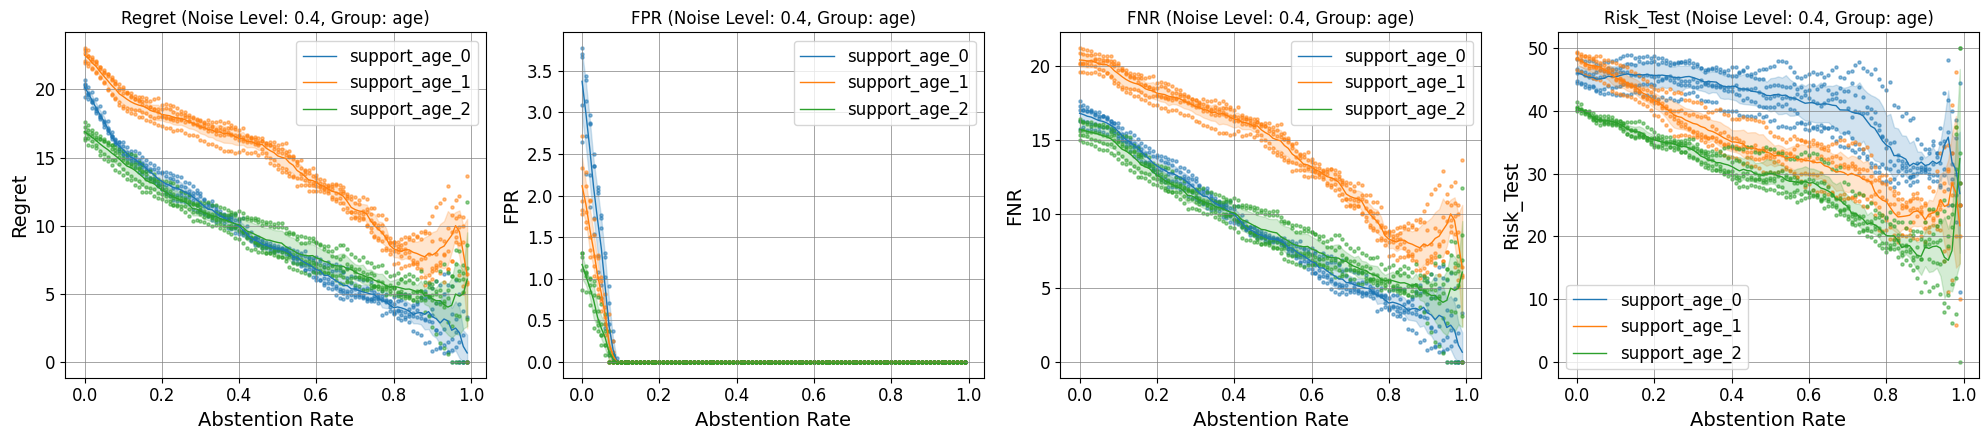

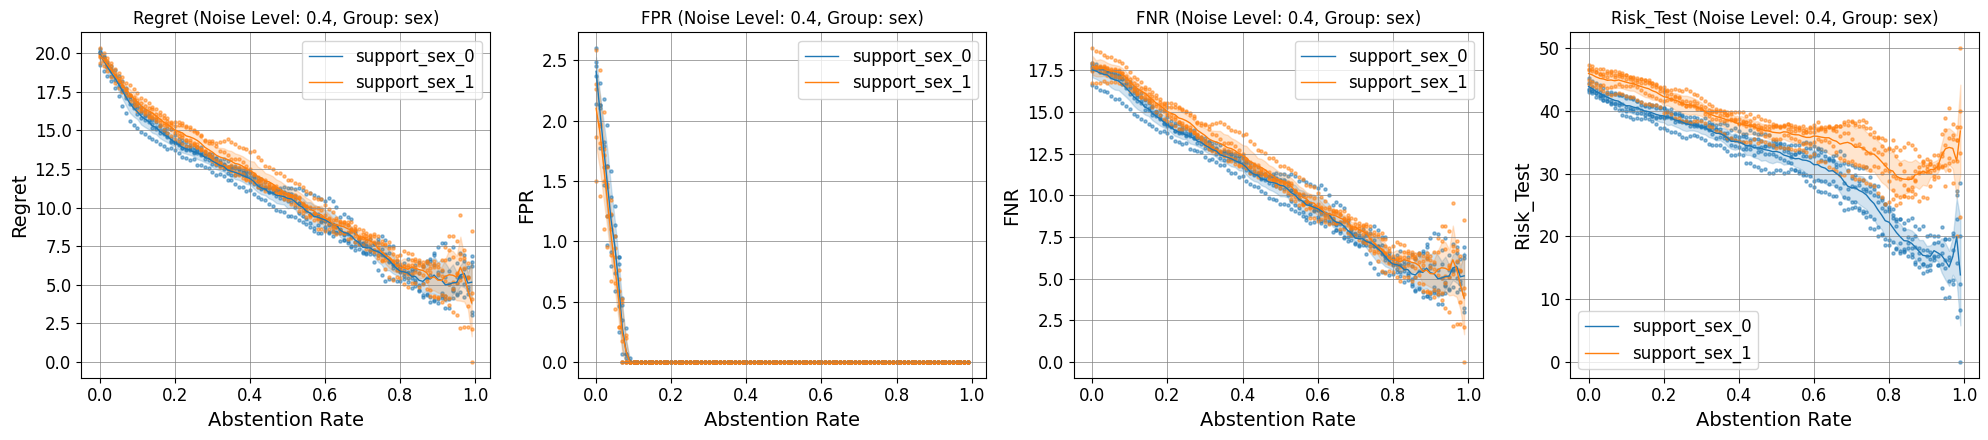

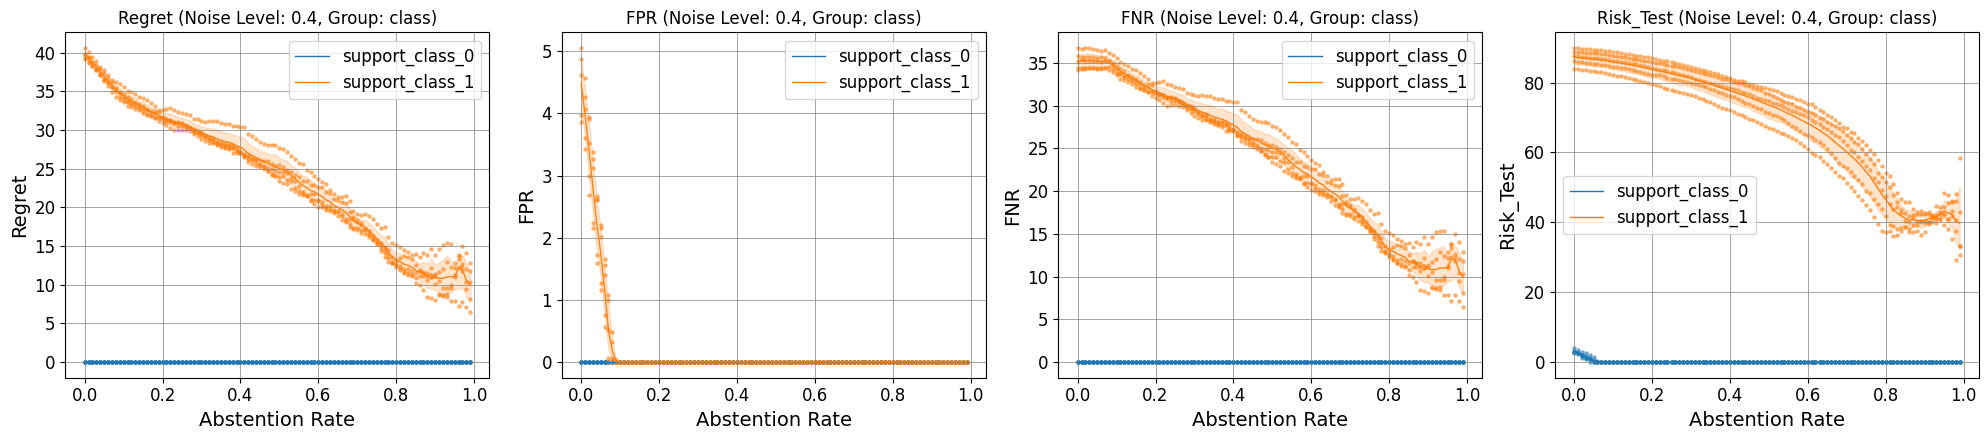

In [30]:
for dataset in tqdm(["cshock_eicu_imbalanced", "cshock_eicu",  "cshock_mimic", "saps", "support", "lungcancer", "saps_imbalanced", "support_imbalanced", "lungcancer_imbalanced"]):
    for model_type in ["NN"]:
        for noise_type in ["class_conditional"]:
#             data = pd.read_csv(f"/h/snagaraj/noise_multiplicity/results/abstain_metrics_{dataset}_{noise_type}_{model_type}_{fixed_class}_{fixed_noise}_{misspecify}.csv")
#             print(dataset)
#             plot_metrics(data)
            try:
                data = pd.read_csv(f"/h/snagaraj/noise_multiplicity/results/abstain_metrics_{dataset}_{noise_type}_{model_type}_{fixed_class}_{fixed_noise}_{misspecify}.csv")
                print(f"{dataset} {noise_type}")
                plot_metrics(data)
            except:
                continue